In [1]:
import os
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from itertools import product
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import LinearRegression, Ridge
import logomaker

#from Bio.Seq import Seq
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from seqtools import *

font = {'family' : 'sans-serif',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")

codon2protein_ = {'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L', 'TCT': 'S', 'TCC': 'S', 'TCA': 'S',
                      'TCG': 'S', 'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*', 'TGT': 'C', 'TGC': 'C',
                      'TGA': '*', 'TGG': 'W', 'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L', 'CCT': 'P',
                      'CCC': 'P', 'CCA': 'P', 'CCG': 'P', 'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
                      'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R', 'ATT': 'I', 'ATC': 'I', 'ATA': 'I',
                      'ATG': 'M', 'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T', 'AAT': 'N', 'AAC': 'N',
                      'AAA': 'K', 'AAG': 'K', 'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R', 'GTT': 'V',
                      'GTC': 'V', 'GTA': 'V', 'GTG': 'V', 'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
                      'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E', 'GGT': 'G', 'GGC': 'G', 'GGA': 'G',
                      'GGG': 'G'}

def get_protein_seq(seq):
    if seq == '#PARENT#':
        return 'WYLQF'
    else:
        protein_seq = ''
        for i in range(0, len(seq), 3):
            codon = seq[i:i+3]
            protein_seq += codon2protein_[codon]
        return protein_seq

def shorten_seq(seq):
    if seq == '#PARENT#':
        return '#PARENT#'
    else:
        return seq[55*3:57*3] + seq[58*3:60*3] + seq[88*3:89*3]

def variant2codons(variant):    
    seq = 'TGGTACCTGCAGTTC'
    if variant == '#PARENT#':
        return seq
    else:
        dict = {166: 0, 167: 1, 168: 2, 169:3, 170:4, 171:5, 175:6, 176:7, 177:8, 178:9, 179:10, 180:11, 265:12, 266: 13, 267:14}
        split = variant.split('_')
        positions = []
        for mut in split:
            position = int(mut[1:-1])
            if position < 166:
                print('issue')
            elif position > 180 and position < 265:
                print('issue')
            elif position not in dict.keys(): #if it's outside of the range
                pass
            else:
                index = dict[position]
                seq = seq[:index] + mut[-1] + seq[index+1:]
        return seq

        

#check for deletion before 89*3
def check_deletion(variant):
    if variant == '#PARENT#':
        return True
    else:
        split = variant.split('_')
        values = []
        #print(split)
        for mut in split:
            if 'DEL' in mut:
                values.append(int(mut[1:-3]))
        if len(values) == 0:
            #print('no deletion')
            return True
        else:
            min = np.min(values)
            #print('deletion')
            return min > 89*3

def reformat(x):
    if (len(x) == 2):
        x = x[0] + '0' + x[1]
    return x

In [2]:
df = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv')
df

,Unnamed: 0.1,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,num_wells,...,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank,NormIso1,NormIso2,Diff
0,0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,1,...,69.0,-648.97722,33,NaN,NaN,NaN,NaN,4.586441,0.765307,3.821134
1,1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,1,...,118.0,-646.67160,48,0.835324,1.329356,20.0,70.0,5.067932,1.291800,3.776133
2,2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,1,...,112.0,-642.32678,97,0.000000,0.000000,155.5,155.5,3.449043,0.594040,2.855002
3,3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,1,...,90.0,-645.07324,60,NaN,NaN,NaN,NaN,4.019563,1.395937,2.623626
4,5,TNMPY,331.0,0.867393,241.0,11.0,484.0,1788.0,367.0,1,...,146.0,-633.74115,162,0.262932,0.495441,52.0,132.0,3.260248,0.669190,2.591058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,183,LQSGA,353.0,0.172635,238.0,12.0,474.0,276.0,2725.0,1,...,130.0,-642.98517,84,0.000000,0.000000,155.5,155.5,0.513877,5.073604,-4.559727
212,186,QYKGD,286.0,0.001800,177.0,4.0,442.0,107.0,2436.0,1,...,80.0,-641.25164,113,0.390436,4.028886,38.0,2.0,0.213644,4.863887,-4.650243
213,213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,1,...,216.0,-629.35627,187,0.075245,2.350554,87.0,19.0,0.120283,4.801761,-4.681477
214,190,NNVER,306.0,0.687294,230.0,7.0,509.0,106.0,2847.0,1,...,176.0,-640.64290,120,NaN,NaN,NaN,NaN,0.183788,4.936261,-4.752473


In [4]:
#take rows where last letter of combo is Y
df = df[df['Combo'].str[-1] == 'Y']
df

,Unnamed: 0.1,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,num_wells,...,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank,NormIso1,NormIso2,Diff
0,0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,1,...,69.0,-648.97722,33,NaN,NaN,NaN,NaN,4.586441,0.765307,3.821134
1,1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,1,...,118.0,-646.67160,48,0.835324,1.329356,20.0,70.0,5.067932,1.291800,3.776133
2,2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,1,...,112.0,-642.32678,97,0.000000,0.000000,155.5,155.5,3.449043,0.594040,2.855002
3,3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,1,...,90.0,-645.07324,60,NaN,NaN,NaN,NaN,4.019563,1.395937,2.623626
4,5,TNMPY,331.0,0.867393,241.0,11.0,484.0,1788.0,367.0,1,...,146.0,-633.74115,162,0.262932,0.495441,52.0,132.0,3.260248,0.669190,2.591058
7,4,AKPPY,75.0,0.774387,175.0,7.0,497.0,2692.0,1163.0,1,...,187.0,-618.95309,207,0.572493,0.622656,26.0,118.0,3.538478,1.528696,2.009782
10,11,TRQPY,334.0,0.635641,202.0,2.0,507.0,2338.0,1531.0,1,...,111.0,-630.90044,175,0.211840,0.690696,57.0,109.0,4.069724,2.664990,1.404734
11,10,AQHYY,87.0,0.742574,288.5,1.5,491.0,2000.5,1155.0,2,...,109.0,-651.63188,12,1.534784,1.120930,12.0,82.0,2.759838,1.596950,1.162888
13,13,SACRY,8.0,0.000737,182.0,10.0,493.0,1692.0,1676.0,1,...,206.0,-643.09466,81,0.525962,0.585926,28.0,121.0,2.242081,2.220879,0.021202


In [66]:
#cleaned_df = merged[merged['VariantsFound'] == 5]
#manually drop well D06
#cleaned_df = cleaned_df.drop(cleaned_df[cleaned_df['Well'] == 'D06'].index)

def process(cleaned_df, activity_col):
    #cleaned_df = cleaned_df[cleaned_df['WellSeqDepth'] > 10]
    #cleaned_df = cleaned_df[cleaned_df['AlignmentFrequency'] > 0.7]


    #there's a simpler way to normalize to parents on the plate but i forgot how
    # for plate in [1, 2, 3, 4]:
    #     plate_df =  cleaned_df[cleaned_df['Plate'] == plate]
    #     mean = plate_df[plate_df['SimpleCombo'] == 'WYLQF'][activity_col].mean()
    #     norm_std = plate_df[plate_df['SimpleCombo'] == 'WYLQF'][activity_col].std()/mean
    #     #print(norm_std)
    #     #divide rows in cleaned_df by mean for that plate
    #     cleaned_df.loc[cleaned_df['Plate'] == plate, activity_col] = cleaned_df.loc[cleaned_df['Plate'] == plate, activity_col]/mean

    expanded_df = cleaned_df.copy()

    indices = cleaned_df[cleaned_df['Combo'] == 'WYLQF'][~cleaned_df['Well'].isin(['B04', 'C05', 'D06', 'E07', 'F08', 'G09'])].index
    cleaned_df = cleaned_df.drop(indices)
    #parent_df = cleaned_df[cleaned_df['Combo'] == 'WYLQF'][cleaned_df['Well'].isin(['B04', 'C05', 'D06', 'E07', 'F08', 'G09'])]
    expanded_df['Control'] = expanded_df['Well'].isin(['B04', 'C05', 'D06', 'E07', 'F08', 'G09'])
    
    
    #cleaned_df = cleaned_df[cleaned_df['Plate'] == 4]
    counts_df = cleaned_df.groupby(['Combo']).size().reset_index()
    cleaned_df = cleaned_df.groupby(['Combo']).mean()
    cleaned_df['num_wells'] = counts_df.iloc[:, 1].values
    cleaned_df = cleaned_df.reset_index().drop('Plate', axis=1)
    cleaned_df[activity_col] = cleaned_df[activity_col]
    #cleaned_df['Fitness'] = cleaned_df['Integration ']/cleaned_df['Integration '].max()

    #take all rows with Combo containing *
    stop_df = cleaned_df[cleaned_df['Combo'].str.contains('\*')]
    mean = stop_df[activity_col].mean()
    std = stop_df[activity_col].std()
    print(mean, std)
    print(stop_df[activity_col].max())

    cleaned_df = cleaned_df[~cleaned_df['Combo'].str.contains('\*')]

    cleaned_df = cleaned_df.sort_values(by=[activity_col], ascending=False)
    return stop_df, expanded_df, cleaned_df

In [21]:
seq_df2 = pd.read_csv('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/ParPgb_variant_df_minION.csv')
seq_df2['Sequence'][0][54*3:55*3] 

'TTG'

In [37]:
data = pd.read_csv('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/ParPgb_variant_df_minION.csv')
data[data['Variant'] == '#PARENT#']

,Plate,Well,Variant,Alignment Probability,Alignment Count,Sequence,Simple Combo
41,1,D6,#PARENT#,0.896397,121.0,#PARENT#,NaN
124,2,C5,#PARENT#,0.925746,60.0,#PARENT#,NaN
207,3,B4,#PARENT#,1.000000,27.0,#PARENT#,NaN
276,3,H1,#PARENT#,0.651660,45.0,#PARENT#,NaN
280,3,H5,#PARENT#,0.881029,79.0,#PARENT#,NaN
289,4,A2,#PARENT#,0.843370,69.0,#PARENT#,NaN
368,4,G9,#PARENT#,0.946180,101.0,#PARENT#,NaN
412,5,C5,#PARENT#,0.811840,112.0,#PARENT#,NaN
438,5,E7,#PARENT#,0.861854,121.0,#PARENT#,NaN
521,6,D6,#PARENT#,0.923925,138.0,#PARENT#,NaN


### For processing Yueming's output

In [4]:
seq_df2 = pd.read_csv('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/ParPgb_minION2.csv')
seq_df2['Well'] = seq_df2['FBC']
seq_df2['Plate'] = seq_df2['RBC'].apply(lambda x: int(x[-2:])- 4)
seq_df2 = seq_df2[seq_df2['Plate'] < 5] #first four plates are 89X, not sure what the rest are
seq_df2.dropna(subset=['Variant'], inplace=True)
seq_df2 = seq_df2[seq_df2['Variant'].apply(check_deletion)]
seq_df2['CodonCombo'] = seq_df2['Variant'].apply(variant2codons)

#seq_df2['SimpleCombo_MinION'] = seq_df2['CodonCombo'].apply(get_protein_seq)
seq_df2['Combo'] = seq_df2['CodonCombo'].apply(get_protein_seq)
seq_df2.drop(['Position', 'RBC', 'FBC'], axis=1, inplace=True)
seq_df2


issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue
issue


,Unnamed: 0,Variant,Alignment Probability,Alignment Count,Row,Column,Well,Plate,CodonCombo,Combo
0,263,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.798821,248.0,A,1,A01,1,ACTAATATGCCTGAG,TNMPE
1,262,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.717116,300.0,A,2,A02,1,ACTAATATGCCTGAG,TNMPE
2,186,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177...,0.572425,410.0,A,3,A03,1,TCTATGAGTCATTGT,SMSHC
3,190,T166G_G167T_A170G_C171T_C175A_T176G_C178G_A179...,0.476841,297.0,A,4,A04,1,GTGTGTAGGGCGTCG,VCRAS
4,277,T166A_G168T_T169A_A170T_C171T_C175G_G177T_C178...,0.610185,424.0,A,5,A05,1,AGTATTGTTAAGACG,SIVKT
...,...,...,...,...,...,...,...,...,...,...
369,129,T166A_G167C_A170C_C171T_C175G_T176G_G177T_C178...,0.235028,156.0,H,8,H08,4,ACGTCTGGTATGTGT,TSGMC
370,120,T166A_G167T_A170G_C171G_T176G_C178A_A179C_C267...,0.363358,455.0,H,9,H09,4,ATGTGGCGGACGTTT,MWRTF
371,163,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177...,0.545897,270.0,H,10,H10,4,TCTATGAGTCATACT,SMSHT
372,136,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.783072,208.0,H,11,H11,4,ACTAATATGCCTCAG,TNMPQ


In [29]:
parent_df = seq_df2[seq_df2['Combo'] == 'WYLQF'][seq_df2['Well'].isin(['B04', 'C05', 'D06', 'E07', 'F08', 'G09'])]
#parent_df.to_csv('parents_sanger.csv', index=False)

/tmp/ipykernel_5425/1199468619.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  parent_df = seq_df2[seq_df2['Combo'] == 'WYLQF'][~seq_df2['Well'].isin(['B04', 'C05', 'D06', 'E07', 'F08', 'G09'])]


In [34]:
index = parent_df.index
#remove these indices from seq_df2
seq_df2.drop(index, inplace=True)
seq_df2

,Unnamed: 0,Variant,Alignment Probability,Alignment Count,Row,Column,Well,Plate,CodonCombo,Combo
0,263,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.798821,248.0,A,1,A01,1,ACTAATATGCCTGAG,TNMPE
1,262,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.717116,300.0,A,2,A02,1,ACTAATATGCCTGAG,TNMPE
2,186,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177...,0.572425,410.0,A,3,A03,1,TCTATGAGTCATTGT,SMSHC
3,190,T166G_G167T_A170G_C171T_C175A_T176G_C178G_A179...,0.476841,297.0,A,4,A04,1,GTGTGTAGGGCGTCG,VCRAS
4,277,T166A_G168T_T169A_A170T_C171T_C175G_G177T_C178...,0.610185,424.0,A,5,A05,1,AGTATTGTTAAGACG,SIVKT
...,...,...,...,...,...,...,...,...,...,...
369,129,T166A_G167C_A170C_C171T_C175G_T176G_G177T_C178...,0.235028,156.0,H,8,H08,4,ACGTCTGGTATGTGT,TSGMC
370,120,T166A_G167T_A170G_C171G_T176G_C178A_A179C_C267...,0.363358,455.0,H,9,H09,4,ATGTGGCGGACGTTT,MWRTF
371,163,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177...,0.545897,270.0,H,10,H10,4,TCTATGAGTCATACT,SMSHT
372,136,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.783072,208.0,H,11,H11,4,ACTAATATGCCTCAG,TNMPQ


### For processing Emre's output

In [16]:
seq_df2 = pd.read_csv('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/ParPgb_variant_df_minION.csv')

# seq_df2.dropna(inplace=True)

#drop rows where "DEL" is in the variant column
seq_df2 = seq_df2[seq_df2['Plate'] < 5] #first four plates are 89X, not sure what the rest are
#seq_df2['Plate'] = seq_df2['Plate'].apply(lambda x: x - 4)
#drop if sequence is nan
seq_df2.dropna(subset=['Sequence'], inplace=True)

#seq_df2 = seq_df2[seq_df2['Variant'] != '#PARENT#']
#seq_df2 = seq_df2[seq_df2['Sequence'].str[54*3:55*3] == 'TTG'] #Make sure there were no deletions before

#apply check deletion to all variants
seq_df2 = seq_df2[seq_df2['Variant'].apply(check_deletion)]


seq_df2['CodonCombo'] = seq_df2['Sequence'].apply(shorten_seq)

#seq_df2['SimpleCombo_MinION'] = seq_df2['CodonCombo'].apply(get_protein_seq)
seq_df2['SimpleCombo'] = seq_df2['CodonCombo'].apply(get_protein_seq)
seq_df2['Well'] = seq_df2['Well'].apply(reformat)
#seq_df2['length'] = seq_df2['Simple Combo'].apply(lambda x: len(x))
#seq_df2[seq_df2['length'] != 16]

seq_df2.drop(['Sequence', 'Simple Combo'], axis=1, inplace=True)

#seq_df = seq_df2

In [19]:
len(seq_df2[seq_df2['SimpleCombo'] == 'WYLQF'])

23

In [4]:
seq_df2[seq_df2['Variant'] == '#PARENT#']

,Plate,Well,Variant,Alignment Probability,Alignment Count,CodonCombo,SimpleCombo
41,1,D06,#PARENT#,0.896397,121.0,#PARENT#,WYLQF
124,2,C05,#PARENT#,0.925746,60.0,#PARENT#,WYLQF
207,3,B04,#PARENT#,1.000000,27.0,#PARENT#,WYLQF
276,3,H01,#PARENT#,0.651660,45.0,#PARENT#,WYLQF
280,3,H05,#PARENT#,0.881029,79.0,#PARENT#,WYLQF
289,4,A02,#PARENT#,0.843370,69.0,#PARENT#,WYLQF
368,4,G09,#PARENT#,0.946180,101.0,#PARENT#,WYLQF


### Merge sequencing and fitness data

In [23]:
seq_df = pd.read_csv('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/AminoAcids_Coupled_Max_evSeq.csv')

#take the last character of the plate column
seq_df['Plate'] = seq_df['Plate'].str[-1]
seq_df['Plate'] = seq_df['Plate'].astype(int)
#remove "a" character from well

seq_df = seq_df[seq_df['WellSeqDepth'] > 10]
seq_df = seq_df[seq_df['AlignmentFrequency'] > 0.7]
#rename simple combo to variant
#seq_df.rename(columns={'SimpleCombo': 'SimpleCombo_evSeq'}, inplace=True)
seq_df.drop(['IndexPlate', 'VariantCombo', 'VariantsFound', 'VariantSequence', 'Flags'], axis=1, inplace=True)

seq_df

,Plate,Well,SimpleCombo,AlignmentFrequency,WellSeqDepth
1,1,A02,TNMPE,0.987616,323
3,1,A04,VCRAS,0.830601,366
4,1,A05,SIVKT,0.991870,123
7,1,A08,SWWSR,1.000000,25
10,1,A11,HDNMG,0.971429,35
...,...,...,...,...,...
364,4,H06,SMSHC,0.987578,161
366,4,H08,TSGMC,0.991131,451
367,4,H09,MWRTF,0.897436,39
368,4,H10,SMSHT,1.000000,23


In [25]:
len(seq_df[seq_df['SimpleCombo'] == 'WYLQF'])

21

### 95% of sequences agree between minION and evSeq (for both minION runs)

In [13]:
#merged = pd.merge(seq_df, seq_df2, on=['Plate', 'Well'], how='inner')
merged = pd.merge(seq_df, seq_df2, on=['Plate', 'Well'], how='outer')
#merged = merged[~merged.duplicated(subset=['Plate', 'Well'])] #naively drop the duplicates and keep evSeq over minion 
#merged.to_csv('merged_seqs_outer.csv', index=False)

#fill SimpleCombo as SimpleCombo2 if nan


merged

,Plate,Well,SimpleCombo,AlignmentFrequency,WellSeqDepth,Unnamed: 0,Variant,Alignment Probability,Alignment Count,Row,Column,CodonCombo,SimpleCombo2
0,1,A02,TNMPE,0.987616,323.0,262.0,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180T_T265G_T266A_C267G,0.717116,300.0,A,2.0,ACTAATATGCCTGAG,TNMPE
1,1,A04,VCRAS,0.830601,366.0,190.0,T166G_G167T_A170G_C171T_C175A_T176G_C178G_A179C_T266C_C267G,0.476841,297.0,A,4.0,GTGTGTAGGGCGTCG,VCRAS
2,1,A05,SIVKT,0.991870,123.0,277.0,T166A_G168T_T169A_A170T_C171T_C175G_G177T_C178A_T265A_T266C_C267G,0.610185,424.0,A,5.0,AGTATTGTTAAGACG,SIVKT
3,1,A08,SWWSR,1.000000,25.0,265.0,G167C_G168T_A170G_C171G_C175T_T176G_C178A_A179G_G180T_T265C_T266G_C267T,0.452282,279.0,A,8.0,TCTTGGTGGAGTCGT,SWWSR
4,1,A11,HDNMG,0.971429,35.0,272.0,T166C_G167A_G168T_T169G_C171T_C175A_T176A_G177T_C178A_A179T_T265G_T266G_C267T,0.470602,461.0,A,11.0,CATGATAATATGGGT,HDNMG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,4,H02,NaN,NaN,NaN,124.0,T166G_G167C_G168T_T169C_C171G_T176A_G177T_C178T_G180T_T265C_T266A_C267G,0.007689,418.0,H,2.0,GCTCAGCATTATCAG,AQHYQ
350,4,H03,NaN,NaN,NaN,90.0,T176A,NaN,257.0,H,3.0,TGGTACCAGCAGTTC,WYQQF
351,4,H05,NaN,NaN,NaN,144.0,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177T_G180T_T266A_C267G,0.006543,237.0,H,5.0,TCTATGAGTCATTAG,SMSH*
352,4,H07,NaN,NaN,NaN,170.0,T166C_G167C_G168T_T169C_A170T_C171G_C175T_C178A_A179T_T265C_T266A_C267G,0.002544,228.0,H,7.0,CCTCTGTTGATGCAG,PLLMQ


In [15]:
agreed = merged[merged['SimpleCombo'] == merged['SimpleCombo2']]
agreed

,Plate,Well,SimpleCombo,AlignmentFrequency,WellSeqDepth,Unnamed: 0,Variant,Alignment Probability,Alignment Count,Row,Column,CodonCombo,SimpleCombo2
0,1,A02,TNMPE,0.987616,323.0,262.0,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180T_T265G_T266A_C267G,0.717116,300.0,A,2.0,ACTAATATGCCTGAG,TNMPE
1,1,A04,VCRAS,0.830601,366.0,190.0,T166G_G167T_A170G_C171T_C175A_T176G_C178G_A179C_T266C_C267G,0.476841,297.0,A,4.0,GTGTGTAGGGCGTCG,VCRAS
2,1,A05,SIVKT,0.991870,123.0,277.0,T166A_G168T_T169A_A170T_C171T_C175G_G177T_C178A_T265A_T266C_C267G,0.610185,424.0,A,5.0,AGTATTGTTAAGACG,SIVKT
3,1,A08,SWWSR,1.000000,25.0,265.0,G167C_G168T_A170G_C171G_C175T_T176G_C178A_A179G_G180T_T265C_T266G_C267T,0.452282,279.0,A,8.0,TCTTGGTGGAGTCGT,SWWSR
4,1,A11,HDNMG,0.971429,35.0,272.0,T166C_G167A_G168T_T169G_C171T_C175A_T176A_G177T_C178A_A179T_T265G_T266G_C267T,0.470602,461.0,A,11.0,CATGATAATATGGGT,HDNMG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,4,H06,SMSHC,0.987578,161.0,180.0,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177T_G180T_T266G_C267T,0.615728,205.0,H,6.0,TCTATGAGTCATTGT,SMSHC
225,4,H08,TSGMC,0.991131,451.0,129.0,T166A_G167C_A170C_C171T_C175G_T176G_G177T_C178A_A179T_T266G_C267T,0.235028,156.0,H,8.0,ACGTCTGGTATGTGT,TSGMC
226,4,H09,MWRTF,0.897436,39.0,120.0,T166A_G167T_A170G_C171G_T176G_C178A_A179C_C267T_G273A,0.363358,455.0,H,9.0,ATGTGGCGGACGTTT,MWRTF
227,4,H10,SMSHT,1.000000,23.0,163.0,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177T_G180T_T265A_T266C_C267T,0.545897,270.0,H,10.0,TCTATGAGTCATACT,SMSHT


In [9]:
merged[merged['SimpleCombo'] == 'TNMPE']

,Plate,Well,SimpleCombo,AlignmentFrequency,WellSeqDepth,Unnamed: 0,Variant,Alignment Probability,Alignment Count,Row,Column,CodonCombo
0,1,A02,TNMPE,0.987616,323.0,262.0,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.717116,300.0,A,2.0,ACTAATATGCCTGAG
5,1,B02,TNMPE,0.948276,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,3,F01,TNMPE,0.983704,1350.0,344.0,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.716174,277.0,F,1.0,ACTAATATGCCTGAG
228,1,A01,TNMPE,NaN,NaN,263.0,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.798821,248.0,A,1.0,ACTAATATGCCTGAG


In [9]:
#merged[merged['SimpleCombo_evSeq'] == merged['SimpleCombo_MinION']]

In [14]:
pd.set_option('display.max_colwidth', None)
wrong_df = merged[merged['SimpleCombo'] != merged['SimpleCombo2']]
#show the full variant column
#wrong_df.to_csv('Issues_evSeq.csv', index=False)
wrong_df.head(20)

,Plate,Well,SimpleCombo,AlignmentFrequency,WellSeqDepth,Unnamed: 0,Variant,Alignment Probability,Alignment Count,Row,Column,CodonCombo,SimpleCombo2
5,1,B02,TNMPE,0.948276,58.0,193.0,T166A_G167C_A170C_C171T_C175G_T176G_G177T_C178A_A179G_T265G_T266A_C267G,0.001915,556.0,B,2.0,ACGTCTGGTAGGGAG,TSGRE
23,1,D05,WYLQF,0.939394,66.0,244.0,G167T_T169C_C171G_C175T_T176C_C178G_A179G_G180T_T265C_C267G,0.033552,636.0,D,5.0,TTGCAGTCGGGTCTG,LQSGL
26,1,D09,PASLV,0.914634,164.0,214.0,T158A_C594A,NaN,404.0,D,9.0,TGGTACCTGCAGTTC,WYLQF
29,1,E02,QYRGD,0.984340,447.0,259.0,T166C_G167C_G168T_T169C_A170T_C171G_C175T_C178A_A179T_C267G,0.347947,346.0,E,2.0,CCTCTGTTGATGTTG,PLLML
32,1,E08,SIVKC,1.000000,84.0,249.0,#PARENT#,1.000000,630.0,E,8.0,TGGTACCTGCAGTTC,WYLQF
37,1,F09,VGV*Q,0.881818,110.0,279.0,G167T_T169C_C171G_C175T_T176C_C178G_A179G_G180T_T265A_T266A_C267G,0.622808,482.0,F,9.0,TTGCAGTCGGGTAAG,LQSGK
42,1,H04,AKPPA,0.702899,138.0,192.0,G167C_T169G_A170C_C171T_C175T_G177T_A179G_G180T_T266G_C267T,0.713073,172.0,H,4.0,TCGGCTTTTCGTTGT,SAFRC
43,1,H05,WYLQSR,0.928571,56.0,239.0,G167T_T169C_C171G_C175T_T176C_C178G_A179G_G180T_T265C_T266A_C267G,0.583323,300.0,H,5.0,TTGCAGTCGGGTCAG,LQSGQ
44,1,H08,SYWGE,0.793103,87.0,224.0,G167C_C171T_C178G_A179G_T265G_T266A_C267G,0.010973,243.0,H,8.0,TCGTATCTGGGGGAG,SYLGE
51,2,A08,TNMPC,0.993103,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Now process fitness

In [67]:
#seq_df = pd.read_csv('merged_seqs_outer.csv')
seq_df = seq_df2
seq_df

,Unnamed: 0,Variant,Alignment Probability,Alignment Count,Row,Column,Well,Plate,CodonCombo,Combo
0,263,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.798821,248.0,A,1,A01,1,ACTAATATGCCTGAG,TNMPE
1,262,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.717116,300.0,A,2,A02,1,ACTAATATGCCTGAG,TNMPE
2,186,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177...,0.572425,410.0,A,3,A03,1,TCTATGAGTCATTGT,SMSHC
3,190,T166G_G167T_A170G_C171T_C175A_T176G_C178G_A179...,0.476841,297.0,A,4,A04,1,GTGTGTAGGGCGTCG,VCRAS
4,277,T166A_G168T_T169A_A170T_C171T_C175G_G177T_C178...,0.610185,424.0,A,5,A05,1,AGTATTGTTAAGACG,SIVKT
...,...,...,...,...,...,...,...,...,...,...
369,129,T166A_G167C_A170C_C171T_C175G_T176G_G177T_C178...,0.235028,156.0,H,8,H08,4,ACGTCTGGTATGTGT,TSGMC
370,120,T166A_G167T_A170G_C171G_T176G_C178A_A179C_C267...,0.363358,455.0,H,9,H09,4,ATGTGGCGGACGTTT,MWRTF
371,163,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177...,0.545897,270.0,H,10,H10,4,TCTATGAGTCATACT,SMSHT
372,136,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.783072,208.0,H,11,H11,4,ACTAATATGCCTCAG,TNMPQ


In [68]:
df = pd.DataFrame()
for i in range(4):
    fitness_df = pd.read_excel('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/5site_ravi_carbene/RL-7-49_Integrations.xlsx', sheet_name=i)
    fitness_df['Plate'] = i + 1
    fitness_df['Well'] = fitness_df['Well'].apply(reformat)
    normalizer = fitness_df[fitness_df['Well'].isin(['B04', 'C05', 'D06', 'E07', 'F08', 'G09'])]['NormIso1'].mean()
    fitness_df['NormIso1'] = fitness_df['NormIso1']/normalizer
    fitness_df['NormIso2'] = fitness_df['NormIso2']/normalizer
    df = df.append(fitness_df)

#move plate column to the front
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
combined = pd.merge(seq_df, df, on=['Plate', 'Well'], how = 'left')
#rename SimpleCombo_evSeq to SimpleCombo
#merged.rename(columns={'SimpleCombo_evSeq': 'SimpleCombo'}, inplace=True)
combined 

/tmp/ipykernel_126298/747692179.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fitness_df)
/tmp/ipykernel_126298/747692179.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fitness_df)
/tmp/ipykernel_126298/747692179.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fitness_df)
/tmp/ipykernel_126298/747692179.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fitness_df)


,Unnamed: 0,Variant,Alignment Probability,Alignment Count,Row,Column,Well,Plate,CodonCombo,Combo,StdArea,Iso1Area,Iso2Area,NormIso1,NormIso2
0,263,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.798821,248.0,A,1,A01,1,ACTAATATGCCTGAG,TNMPE,501,149.0,3585.0,0.205694,4.949078
1,262,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.717116,300.0,A,2,A02,1,ACTAATATGCCTGAG,TNMPE,493,224.0,3162.0,0.314249,4.435962
2,186,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177...,0.572425,410.0,A,3,A03,1,TCTATGAGTCATTGT,SMSHC,499,588.0,2823.0,0.814985,3.912760
3,190,T166G_G167T_A170G_C171T_C175A_T176G_C178G_A179...,0.476841,297.0,A,4,A04,1,GTGTGTAGGGCGTCG,VCRAS,501,200.0,3415.0,0.276099,4.714394
4,277,T166A_G168T_T169A_A170T_C171T_C175G_G177T_C178...,0.610185,424.0,A,5,A05,1,AGTATTGTTAAGACG,SIVKT,504,356.0,3369.0,0.488531,4.623207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,129,T166A_G167C_A170C_C171T_C175G_T176G_G177T_C178...,0.235028,156.0,H,8,H08,4,ACGTCTGGTATGTGT,TSGMC,514,326.0,2176.0,0.441026,2.943782
339,120,T166A_G167T_A170G_C171G_T176G_C178A_A179C_C267...,0.363358,455.0,H,9,H09,4,ATGTGGCGGACGTTT,MWRTF,518,640.0,1530.0,0.859132,2.053864
340,163,G167C_G168T_T169A_A170T_C171G_C175A_T176G_G177...,0.545897,270.0,H,10,H10,4,TCTATGAGTCATACT,SMSHT,515,439.0,2511.0,0.592744,3.390388
341,136,T166A_G167C_G168T_T169A_C171T_C175A_A179C_G180...,0.783072,208.0,H,11,H11,4,ACTAATATGCCTCAG,TNMPQ,508,217.0,2748.0,0.297034,3.761516


In [69]:
stop_df1, expanded_df1, merged_cleaned = process(combined, 'NormIso1')
stop_df2, expanded_df2, cleaned_df2 = process(combined, 'NormIso2')

0.21648035356148365 0.13082186456122297
0.5858663931169737
2.0632806247748174 1.3455470089116666
4.443522232643792


/tmp/ipykernel_126298/1347415080.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indices = cleaned_df[cleaned_df['Combo'] == 'WYLQF'][~cleaned_df['Well'].isin(['B04', 'C05', 'D06', 'E07', 'F08', 'G09'])].index
/tmp/ipykernel_126298/1347415080.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cleaned_df = cleaned_df.groupby(['Combo']).mean()
/tmp/ipykernel_126298/1347415080.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indices = cleaned_df[cleaned_df['Combo'] == 'WYLQF'][~cleaned_df['Well'].isin(['B04', 'C05', 'D06', 'E07', 'F08', 'G09'])].index
/tmp/ipykernel_126298/1347415080.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default t

In [70]:
merged_cleaned

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,NormIso2,num_wells
140,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,5.067932,1.291800,1
30,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,4.586441,0.765307,1
174,SWWSW,363.0,0.374677,263.0,3.0,481.0,2375.0,1239.0,4.357596,2.273289,1
203,TRQPY,334.0,0.635641,202.0,2.0,507.0,2338.0,1531.0,4.069724,2.664990,1
216,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,4.019563,1.395937,1
...,...,...,...,...,...,...,...,...,...,...,...
88,PASLP,283.0,0.335944,190.0,8.0,481.0,50.0,292.0,0.091739,0.535755,1
149,SLGMV,242.0,0.128405,452.0,12.0,469.0,58.0,1715.0,0.085532,2.529089,1
190,TNMPN,205.0,0.834816,683.0,12.0,505.0,51.0,1618.0,0.069848,2.215950,1
123,QYRGP,172.0,0.297243,185.5,9.0,517.5,49.5,314.5,0.064216,0.408045,2


In [71]:
cleaned_df2

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,NormIso2,num_wells
61,LQSGA,353.0,0.172635,238.0,12.0,474.0,276.0,2725.0,0.513877,5.073604,1
84,NNVER,306.0,0.687294,230.0,7.0,509.0,106.0,2847.0,0.183788,4.936261,1
217,TSGRE,193.0,0.001915,556.0,2.0,490.0,107.0,3496.0,0.151029,4.934558,1
113,QYKGD,286.0,0.001800,177.0,4.0,442.0,107.0,2436.0,0.213644,4.863887,1
91,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.120283,4.801761,1
...,...,...,...,...,...,...,...,...,...,...,...
39,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,3.449043,0.594040,1
88,PASLP,283.0,0.335944,190.0,8.0,481.0,50.0,292.0,0.091739,0.535755,1
122,QYRGL,370.0,0.216886,345.0,5.0,461.0,28.0,231.0,0.053603,0.442221,1
123,QYRGP,172.0,0.297243,185.5,9.0,517.5,49.5,314.5,0.064216,0.408045,2


In [72]:
merged_cleaned = pd.merge(merged_cleaned.drop('NormIso2', axis=1), cleaned_df2[['Combo', 'NormIso2']])
merged_cleaned['Diff'] = merged_cleaned['NormIso1'] - merged_cleaned['NormIso2']
merged_cleaned = merged_cleaned.sort_values(by=['Diff'], ascending=False)
merged_cleaned

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff
1,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,4.586441,1,0.765307,3.821134
0,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,5.067932,1,1.291800,3.776133
7,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,3.449043,1,0.594040,2.855002
4,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,4.019563,1,1.395937,2.623626
8,TNMPY,331.0,0.867393,241.0,11.0,484.0,1788.0,367.0,3.260248,1,0.669190,2.591058
...,...,...,...,...,...,...,...,...,...,...,...,...
59,LQSGA,353.0,0.172635,238.0,12.0,474.0,276.0,2725.0,0.513877,1,5.073604,-4.559727
168,QYKGD,286.0,0.001800,177.0,4.0,442.0,107.0,2436.0,0.213644,1,4.863887,-4.650243
204,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.120283,1,4.801761,-4.681477
185,NNVER,306.0,0.687294,230.0,7.0,509.0,106.0,2847.0,0.183788,1,4.936261,-4.752473


(0.0, 4.0)

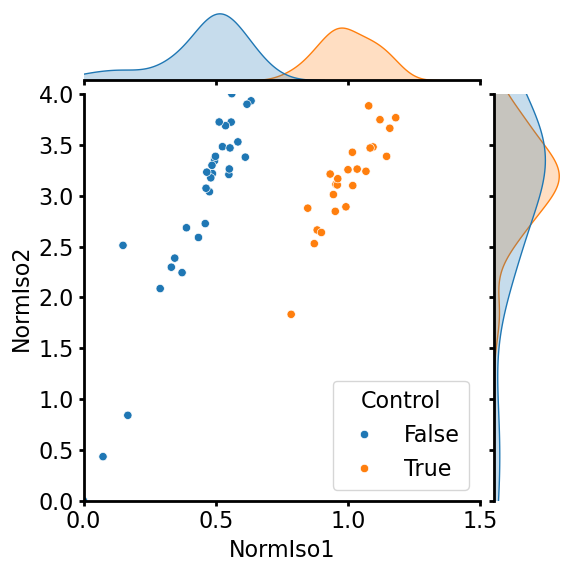

In [73]:
subset_df = expanded_df1[expanded_df1['Combo'] == 'WYLQF']
sns.jointplot(x='NormIso1', y='NormIso2', data= subset_df, hue='Control')
plt.xlim(0,1.5)
plt.ylim(0,4)

In [74]:
old_df = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness_unnormalized.csv')
new = pd.merge(old_df.drop(['NormIso1', 'NormIso2', 'Diff'], axis = 1), merged_cleaned[['Combo', 'NormIso1', 'NormIso2', 'Diff']], on=['Combo'], how='left')
new = new.sort_values(by=['Diff'], ascending=False)
new

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,num_wells,EVMutation,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank,NormIso1,NormIso2,Diff
0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,1,-28.982647,69.0,-648.97722,33,NaN,NaN,NaN,NaN,4.586441,0.765307,3.821134
1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,1,-31.842763,118.0,-646.67160,48,0.835324,1.329356,20.0,70.0,5.067932,1.291800,3.776133
2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,1,-31.299863,112.0,-642.32678,97,0.000000,0.000000,155.5,155.5,3.449043,0.594040,2.855002
3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,1,-29.967584,90.0,-645.07324,60,NaN,NaN,NaN,NaN,4.019563,1.395937,2.623626
5,TNMPY,331.0,0.867393,241.0,11.0,484.0,1788.0,367.0,1,-33.636411,146.0,-633.74115,162,0.262932,0.495441,52.0,132.0,3.260248,0.669190,2.591058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,LQSGA,353.0,0.172635,238.0,12.0,474.0,276.0,2725.0,1,-32.559556,130.0,-642.98517,84,0.000000,0.000000,155.5,155.5,0.513877,5.073604,-4.559727
186,QYKGD,286.0,0.001800,177.0,4.0,442.0,107.0,2436.0,1,-29.577335,80.0,-641.25164,113,0.390436,4.028886,38.0,2.0,0.213644,4.863887,-4.650243
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,1,-38.626022,216.0,-629.35627,187,0.075245,2.350554,87.0,19.0,0.120283,4.801761,-4.681477
190,NNVER,306.0,0.687294,230.0,7.0,509.0,106.0,2847.0,1,-34.952975,176.0,-640.64290,120,NaN,NaN,NaN,NaN,0.183788,4.936261,-4.752473


In [75]:
new[new['Combo'] == 'WYLQF']

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,num_wells,EVMutation,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank,NormIso1,NormIso2,Diff
82,WYLQF,187.416667,0.960474,227.25,6.5,491.583333,682.208333,2156.083333,24,-10.557092,1.0,-663.60981,2,1.0,1.0,17.0,88.0,1.0,3.149412,-2.149412


In [56]:
new.to_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv')

In [41]:
merged_cleaned.head(20)

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff
1,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,7.020661,1,1.171488,5.849174
0,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,7.757700,1,1.977413,5.780287
5,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,4.960080,1,0.854291,4.105788
2,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,6.152918,1,2.136821,4.016097
3,AKPPY,75.0,0.774387,175.0,7.0,497.0,2692.0,1163.0,5.416499,1,2.340040,3.076459
11,TNMPY,331.0,0.867393,241.0,11.0,484.0,1788.0,367.0,3.694215,1,0.758264,2.935950
15,TSGMW,346.0,0.308917,266.0,10.0,476.0,1373.0,104.0,2.884454,1,0.218487,2.665966
6,SWWSW,363.0,0.374677,263.0,3.0,481.0,2375.0,1239.0,4.937630,1,2.575884,2.361746
4,HPTYV,26.0,0.557840,338.0,9.0,496.0,2634.0,1512.0,5.310484,1,3.048387,2.262097
8,HDNMW,102.0,0.016019,219.0,9.0,501.0,2146.0,1130.0,4.283433,1,2.255489,2.027944


In [42]:
merged_cleaned.sort_values(by=['num_wells'], ascending=False)

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff
29,WYLQF,187.416667,0.960474,227.250000,6.500000,491.583333,682.208333,2156.083333,1.386954,24,4.382704,-2.995749
75,TSGML,219.600000,0.222809,308.600000,3.400000,483.000000,289.800000,1708.800000,0.595710,5,3.530707,-2.934996
90,SMSHL,179.500000,0.562425,198.000000,7.500000,496.500000,262.250000,1847.500000,0.528024,4,3.723198,-3.195175
185,SIVKG,253.000000,0.333622,273.666667,4.666667,479.333333,119.666667,2366.666667,0.249317,3,4.939713,-4.690395
85,TNMPV,243.000000,0.633754,278.333333,9.666667,498.666667,273.333333,1473.666667,0.548040,3,2.954629,-2.406589
...,...,...,...,...,...,...,...,...,...,...,...,...
204,QYMPG,168.000000,0.778125,414.000000,3.000000,494.000000,85.000000,1542.000000,0.172065,1,3.121457,-2.949393
104,TNMPC,338.000000,0.005141,92.000000,12.000000,501.000000,246.000000,1732.000000,0.491018,1,3.457086,-2.966068
110,QYRGR,118.000000,0.293594,208.000000,12.000000,493.000000,234.000000,1721.000000,0.474645,1,3.490872,-3.016227
28,PLLMV,211.000000,0.359665,324.000000,12.000000,505.000000,707.000000,2244.000000,1.400000,1,4.443564,-3.043564


In [7]:
#merged_cleaned.to_csv('Pgb_fitness.csv', index=False)

In [8]:
merged_cleaned = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv')
merged_cleaned

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff,EVMutation,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank
0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,7.020661,1,1.171488,5.849174,-28.982647,69.0,-648.97722,33,NaN,NaN,NaN,NaN
1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,7.757700,1,1.977413,5.780287,-31.842763,118.0,-646.67160,48,0.835324,1.329356,20.0,70.0
2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,4.960080,1,0.854291,4.105788,-31.299863,112.0,-642.32678,97,0.000000,0.000000,155.5,155.5
3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,6.152918,1,2.136821,4.016097,-29.967584,90.0,-645.07324,60,NaN,NaN,NaN,NaN
4,AKPPY,75.0,0.774387,175.0,7.0,497.0,2692.0,1163.0,5.416499,1,2.340040,3.076459,-35.509484,187.0,-618.95309,207,0.572493,0.622656,26.0,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,VCRAS,190.0,0.476841,297.0,4.0,501.0,200.0,3415.0,0.399202,1,6.816367,-6.417166,-29.500047,78.0,-641.07042,115,0.092975,2.684590,80.0,10.0
212,HDNMN,173.0,0.155533,277.0,4.0,501.0,148.0,3378.0,0.295409,1,6.742515,-6.447106,-29.217710,72.0,-642.37494,94,NaN,NaN,NaN,NaN
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.173913,1,6.942688,-6.768775,-38.626022,216.0,-629.35627,187,0.075245,2.350554,87.0,19.0
214,ACSEK,60.0,0.655179,483.0,8.0,490.0,243.0,3579.0,0.495918,1,7.304082,-6.808163,-34.614352,172.0,-639.54535,132,0.101182,2.295279,74.0,21.0


In [9]:
merged_cleaned.sort_values(by=['Diff'], ascending=True).head(20)

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff,EVMutation,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank
215,TSGRE,193.0,0.001915,556.0,2.0,490.0,107.0,3496.0,0.218367,1,7.134694,-6.916327,-35.417786,185.0,-639.24294,135,0.093254,1.108917,79.0,83.0
214,ACSEK,60.0,0.655179,483.0,8.0,490.0,243.0,3579.0,0.495918,1,7.304082,-6.808163,-34.614352,172.0,-639.54535,132,0.101182,2.295279,74.0,21.0
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.173913,1,6.942688,-6.768775,-38.626022,216.0,-629.35627,187,0.075245,2.350554,87.0,19.0
212,HDNMN,173.0,0.155533,277.0,4.0,501.0,148.0,3378.0,0.295409,1,6.742515,-6.447106,-29.217710,72.0,-642.37494,94,NaN,NaN,NaN,NaN
211,VCRAS,190.0,0.476841,297.0,4.0,501.0,200.0,3415.0,0.399202,1,6.816367,-6.417166,-29.500047,78.0,-641.07042,115,0.092975,2.684590,80.0,10.0
210,ACSEQ,20.0,0.678377,50.0,10.0,487.0,220.0,3307.0,0.451745,1,6.790554,-6.338809,-33.573294,143.0,-640.27065,125,0.091878,2.332957,82.0,20.0
209,PCLTS,195.0,0.749372,290.0,6.0,503.0,166.0,3330.0,0.330020,1,6.620278,-6.290258,-34.544754,170.0,-631.24536,172,0.014163,1.152981,125.0,80.0
208,RSARI,175.0,0.266918,190.0,9.0,471.0,246.0,3176.0,0.522293,1,6.743100,-6.220807,-33.014863,136.0,-639.89363,129,NaN,NaN,NaN,NaN
207,PPHNG,46.0,0.629988,190.0,11.0,489.0,431.0,3377.0,0.881391,1,6.905930,-6.024540,-38.167989,212.0,-615.69023,213,NaN,NaN,NaN,NaN
206,PASLE,51.0,0.305626,441.0,11.0,505.0,175.0,3195.0,0.346535,1,6.326733,-5.980198,-34.054854,157.0,-629.83618,182,0.000000,0.000000,155.5,155.5


In [10]:
#select rows where Combo ends in Y
WT = merged_cleaned[merged_cleaned['Combo'] == 'WYLQF']

NameError: name 'singles_df' is not defined

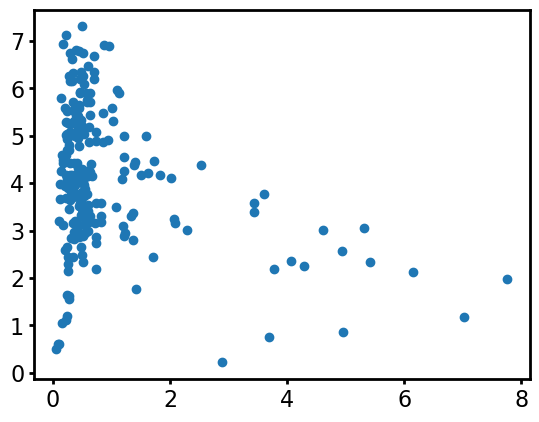

In [11]:
plt.plot(merged_cleaned['NormIso1'], merged_cleaned['NormIso2'], 'o')
plt.plot(singles_df['NormIso1'], singles_df['NormIso2'], 'o')
plt.plot(WT['NormIso1'], WT['NormIso2'], 'o')
plt.xlabel('Cis Isomer')
plt.ylabel('Trans Isomer')
plt.grid()
plt.axis('equal')

216
216


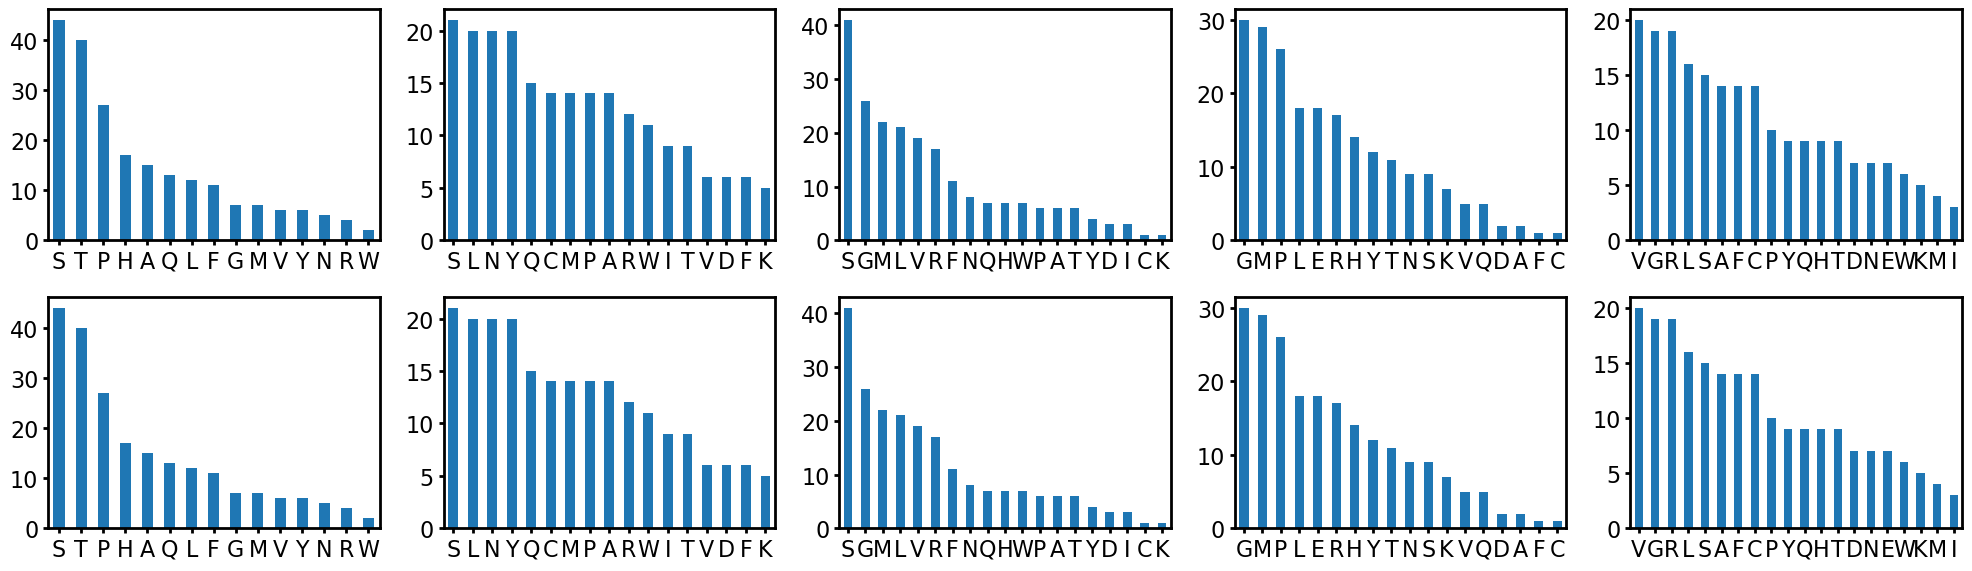

In [16]:
plt.figure(figsize=(20, 6))
for i in [1]:
    for j in  [0, 1]:
        sites = 5
        labels = ['AA1', 'AA2', 'AA3', 'AA4', 'AA5']
        if j == 0:
            #batch = merged_cleaned[merged_cleaned['NormIso1'] > 0] # can also use 1
            batch = merged_cleaned
        
        #second column is the distribution of live variants
        # if j == 1:
        #     batch = merged_cleaned[merged_cleaned['Diff'] > 0]

        print(len(batch))
        
        for l in range(sites):
            batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])

        for k, label  in enumerate(labels):
            plt.subplot(2, 5, k + 5*j + 1)
            batch[label].value_counts().plot(kind="bar")
            plt.xticks(rotation=0)
            #sns.countplot(x=label, data=batch)
plt.tight_layout()

In [17]:
def plot_logo(batch, acquisition):
  dfs = []
  for i in range(1, 6):
      temp = batch.groupby(f'AA{i}').count()
      temp[i] = temp.mean(axis=1)
      temp = temp[[i]]
      temp.index.name = ''
      temp = temp.copy().T
      dfs.append(temp)
  
  df = pd.concat(dfs)
  #replace nan with 0
  df = df.fillna(0)
  #normalize rows to 1
  df = df.div(df.sum(axis=1), axis=0)
  df

  # create Logo object
  AAs_logo = logomaker.Logo(df,
                            color_scheme='weblogo_protein',
                            #font_name='Arial',
                            vpad=.15,
                            figsize=(3, 2.5),
                          #   baseline_width=.8,
  )

  # additional styling using Logo methods
  AAs_logo.style_spines(visible=False)

  # style using Axes methods
  AAs_logo.ax.set_ylim([0, 1])
  AAs_logo.ax.set_ylabel('frequency', labelpad=0)
  AAs_logo.ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  AAs_logo.ax.set_xticks([1,2,3,4, 5])
  AAs_logo.ax.set_title(acquisition)

  return

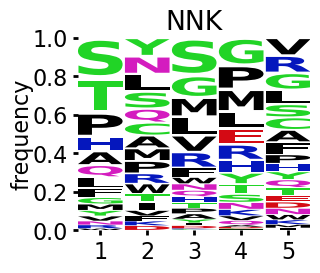

In [18]:
plot_logo(batch, 'NNK')

In [30]:
# fitness_df1 = pd.read_excel('/home/jyang4/repos/StARDUST/data/ParPgb/5site_ravi_new/fivesite_P1-3.xlsx')

# fitness_df2 = pd.read_excel('/home/jyang4/repos/StARDUST/data/ParPgb/5site_ravi_new/RL-7-46_P4.xls')
# fitness_df2['Plate'] = 4
# #rename area to integration in columns
# fitness_df2.rename(columns={'Area':'Integration'}, inplace=True)

# merged = pd.merge(fitness_df1, fitness_df2, on=['Plate', 'Well'])
fitness_df1 = pd.read_excel('/home/jyang4/repos/data/from_StARDUST/ParPgb/5site_ravi_new/fivesite_P1-4.xlsx')
fitness_df2 = pd.read_excel('/home/jyang4/repos/data/from_StARDUST/ParPgb/5site_ravi_new/fivesite_P1-4_2.xlsx')


fitness_df1['Well'] = fitness_df1['Well'].apply(reformat)
fitness_df2['Well'] = fitness_df2['Well'].apply(reformat)

fitness_df2

,Plate,Well,Area
0,1,A01,115654
1,1,A02,135664
2,1,A03,124441
3,1,A04,149012
4,1,A05,132017
...,...,...,...
371,4,H08,408617
372,4,H09,231700
373,4,H10,257741
374,4,H11,279831


In [31]:
merged = pd.merge(fitness_df1, fitness_df2, on=['Plate', 'Well'], how = 'left') 
merged = pd.merge(merged, seq_df, on=['Plate', 'Well'], how = 'left') 
#merged.to_csv('/home/jyang4/repos/StARDUST/data/ParPgb/5site_ravi_new/5site_merged.csv', index=False)  
#rename integration to area1
merged.rename(columns={'Integration ':'Area1', 'Area':'Area2'}, inplace=True)
merged


,Plate,Well,Area1,Area2,IndexPlate,VariantCombo,SimpleCombo,VariantsFound,AlignmentFrequency,WellSeqDepth,VariantSequence,Flags
0,1,A01,0.0,115654.0,DI01,#DEAD#,#DEAD#,0.0,0.000000,0.0,#DEAD#,Too few usable reads
1,1,A02,653911.4,135664.0,DI01,?56T_?57N_?59M_?60P_?89E,TNMPE,5.0,0.987616,323.0,ACEALKGQVEDILDLTNGMPGSNQHLIYYFGDKSGRPIPQYLEAVRKRE,NaN
2,1,A03,551486.8,124441.0,DI01,?56S_?57M_?59S_?60H_?89C,SMSHC,5.0,0.900000,10.0,ACEALKGQVEDILDLSMGSHGSNQHLIYYFGDKSGRPIPQYLEAVRKRC,NaN
3,1,A04,200618.3,149012.0,DI01,?56V_?57C_?59R_?60A_?89S,VCRAS,5.0,0.830601,366.0,ACEALKGQVEDILDLVCGRAGSNQHLIYYFGDKSGRPIPQYLEAVRKRS,NaN
4,1,A05,612350.0,132017.0,DI01,?56S_?57I_?59V_?60K_?89T,SIVKT,5.0,0.991870,123.0,ACEALKGQVEDILDLSIGVKGSNQHLIYYFGDKSGRPIPQYLEAVRKRT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
379,4,H08,686017.0,408617.0,DI05,?56T_?57S_?59G_?60M_?89C,TSGMC,5.0,0.991131,451.0,ACEALKGQVEDILDLTSGGMGSNQHLIYYFGDKSGRPIPQYLEAVRKRC,NaN
380,4,H09,309529.0,231700.0,DI05,?56M_?57W_?59R_?60T_?89F,MWRTF,5.0,0.897436,39.0,ACEALKGQVEDILDLMWGRTGSNQHLIYYFGDKSGRPIPQYLEAVRKRF,NaN
381,4,H10,38342.0,257741.0,DI05,?56S_?57M_?59S_?60H_?89T,SMSHT,5.0,1.000000,23.0,ACEALKGQVEDILDLSMGSHGSNQHLIYYFGDKSGRPIPQYLEAVRKRT,NaN
382,4,H11,205059.0,279831.0,DI05,?56T_?57N_?59M_?60P_?89Q,TNMPQ,5.0,0.995833,240.0,ACEALKGQVEDILDLTNGMPGSNQHLIYYFGDKSGRPIPQYLEAVRKRQ,NaN


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


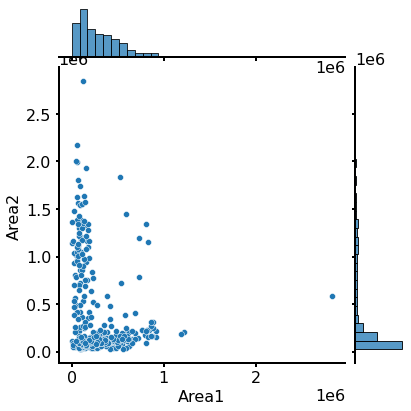

In [32]:
sns.jointplot(x='Area1', y='Area2', data=merged)

In [34]:
#take a look at WT
merged[merged['SimpleCombo'] == 'VGV*D']

,Plate,Well,Area1,Area2,IndexPlate,VariantCombo,SimpleCombo,VariantsFound,AlignmentFrequency,WellSeqDepth,VariantSequence,Flags
47,1,D12,878797.5,160396.0,DI01,?56V_?57G_?59V_?60*_?89D,VGV*D,5.0,0.989583,96.0,ACEALKGQVEDILDLVGGV*GSNQHLIYYFGDKSGRPIPQYLEAVRKRD,NaN


### normalize to parents on each plate

In [69]:
stop_df1, expanded_df1, merged_cleaned = process(cleaned_df, 'Area1')
stop_df2, expanded_df2, cleaned_df2 = process(cleaned_df, 'Area2')
cleaned_merged = pd.merge(merged_cleaned.drop(['Area2'], axis=1), cleaned_df2[['SimpleCombo', 'Area2']], on=['SimpleCombo'], how='left')
expanded_merged = pd.merge(expanded_df1.drop(['Area2', 'SimpleCombo'], axis=1), expanded_df2[['Plate', 'Well', 'SimpleCombo', 'Area2']], on=['Plate', 'Well'], how='left')
cleaned_merged = cleaned_merged.sort_values(by=['Area2'], ascending=False)

0.3707664699153827 0.32808646700671174
1.3406948798002905
0.5733714455260511 0.3060223802631206
1.2454976358251002


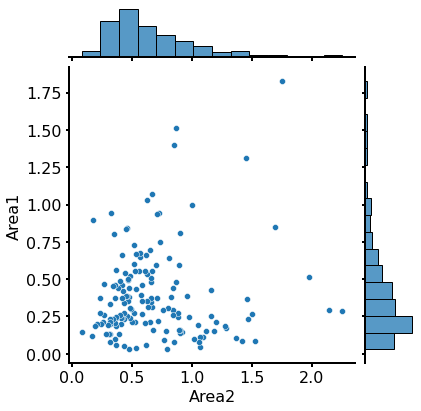

In [72]:
sns.jointplot(x='Area2', y='Area1', data=cleaned_merged)

In [73]:
cleaned_merged[:30]

,SimpleCombo,Area1,VariantsFound,AlignmentFrequency,WellSeqDepth,num_wells,Area2
83,PCLTS,0.283376,5.0,1.000000,11.000000,1,2.257966
82,TRQPD,0.290224,5.0,0.972222,36.000000,1,2.145733
39,TNMPT,0.517473,5.0,0.802005,399.000000,1,1.974963
0,YLSLV,1.828617,5.0,0.762681,963.500000,2,1.749689
11,TSGMC,0.850949,5.0,0.991131,451.000000,1,1.691828
145,PPHNG,0.089021,5.0,0.992913,1411.000000,1,1.524600
89,YLSLA,0.265594,5.0,0.996296,270.000000,1,1.505850
104,PCLTH,0.230283,5.0,0.992324,1433.000000,1,1.471727
68,PTGEL,0.364938,5.0,0.985955,541.500000,2,1.458121
3,SYWGE,1.314964,5.0,0.793103,87.000000,1,1.453254


### Performance of this one is weird, check

In [74]:
expanded_merged[expanded_merged['SimpleCombo'] == 'YLSLV']

,Plate,Well,Area1,IndexPlate,VariantCombo,VariantsFound,AlignmentFrequency,WellSeqDepth,VariantSequence,Flags,SimpleCombo,Area2
61,2,C01,0.143797,DI03,?56Y_?57L_?59S_?60L_?89V,5.0,0.800196,1021.0,ACEALKGQVEDILDLYLGSLGSNQHLIYYFGDKSGRPIPQYLEAVRKRV,NaN,YLSLV,1.059335
186,4,C06,3.513436,DI05,?56Y_?57L_?59S_?60L_?89V,5.0,0.725166,906.0,ACEALKGQVEDILDLYLGSLGSNQHLIYYFGDKSGRPIPQYLEAVRKRV,NaN,YLSLV,2.440043


In [14]:
cleaned_merged['Fitness'].hist()
plt.xlabel('Fitness')

KeyError: 'Fitness'

In [12]:
cleaned_df.rename(columns={'SimpleCombo':'Combo'}, inplace=True)
cleaned_df[cleaned_df['Combo'].str[4] == 'F']

### Look at the singles

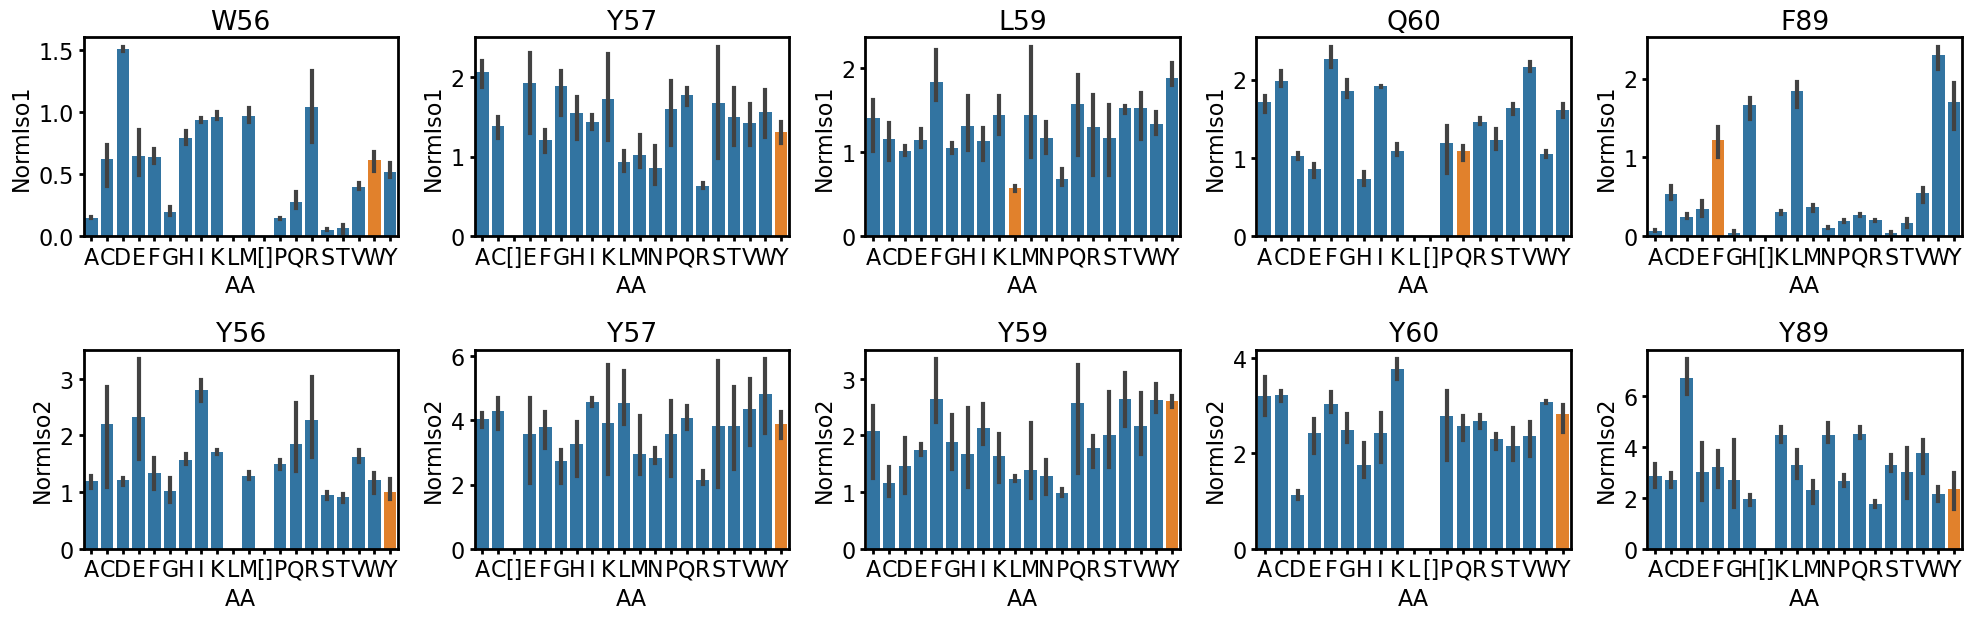

In [64]:
parent_residues = ['W', 'Y', 'L', 'Q', 'F']
number = ['56', '57', '59', '60', '89']
i = 0
plt.figure(figsize=(20, 9))
map_dict = {}
#make an empty nested dictionary

combos = []
NormIso1 = []
NormIso2 = []

for column in ['NormIso1', 'NormIso2']: #['NormIso1', 'NormIso2', 'Diff']
    map_dict[column] = {}
    for sheet, residue in zip(range(5), parent_residues):
        map_dict[column][sheet] = {}
        plt.subplot(3, 5, i+1)
        i += 1
        data = pd.read_excel('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/5site_ravi_carbene/RL-7-50_SSM_AllData_56X-60X+89X.xlsx', sheet_name=sheet) 
        #replace Sterile with []
        data['AA'] = data['AA'].apply(lambda x: x.replace('Sterile', '[]'))
        data['WT'] = data['AA'] == residue
        
        #normalize everything to mean of WT
        #data[column] = data[column]/data[data['WT']][column].mean()

        #barplot with the resude of interest colored
        plt.title(residue + number[sheet])
        

        #data['Diff'] = data['NormIso1'] - data['NormIso2']
        sns.barplot(x='AA', y=column, data=data, hue ='WT')
        
        for aa in ALL_AAS:
            mean = data[data['AA'] == aa][column].mean()
            # if np.isnan(mean):
            #     mean = 1
            map_dict[column][sheet][aa] = mean

            residues = parent_residues
            residues[sheet] = aa
            combo = ''.join(residues)
            
            if column == 'NormIso1':
                combos.append(combo)
                NormIso1.append(mean)
            else:
                NormIso2.append(mean)
                

        #remove legend
        #plt.ylim(0, 3.5)

        
        
        plt.legend([],[], frameon=False)

dict = {'Combo': combos, 'NormIso1': NormIso1, 'NormIso2': NormIso2,}
singles_df = pd.DataFrame(dict)
plt.tight_layout()

In [68]:
singles_df = singles_df.groupby('Combo').mean().reset_index()
singles_df

,Combo,NormIso1,NormIso2
0,AYLQF,0.147960,1.196056
1,CYLQF,0.627860,2.198417
2,DYLQF,1.512636,1.207363
3,EYLQF,0.649914,2.319655
4,FYLQF,0.637399,1.337887
...,...,...,...
91,YYYYS,0.046439,3.276353
92,YYYYT,0.167991,3.025493
93,YYYYV,0.544944,3.755683
94,YYYYW,2.296733,2.133558


In [48]:
fitness_df = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv')
fitness_df

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff,EVMutation,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank
0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,7.020661,1,1.171488,5.849174,-28.982647,69.0,-648.97722,33,NaN,NaN,NaN,NaN
1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,7.757700,1,1.977413,5.780287,-31.842763,118.0,-646.67160,48,0.835324,1.329356,20.0,70.0
2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,4.960080,1,0.854291,4.105788,-31.299863,112.0,-642.32678,97,0.000000,0.000000,155.5,155.5
3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,6.152918,1,2.136821,4.016097,-29.967584,90.0,-645.07324,60,NaN,NaN,NaN,NaN
4,AKPPY,75.0,0.774387,175.0,7.0,497.0,2692.0,1163.0,5.416499,1,2.340040,3.076459,-35.509484,187.0,-618.95309,207,0.572493,0.622656,26.0,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,VCRAS,190.0,0.476841,297.0,4.0,501.0,200.0,3415.0,0.399202,1,6.816367,-6.417166,-29.500047,78.0,-641.07042,115,0.092975,2.684590,80.0,10.0
212,HDNMN,173.0,0.155533,277.0,4.0,501.0,148.0,3378.0,0.295409,1,6.742515,-6.447106,-29.217710,72.0,-642.37494,94,NaN,NaN,NaN,NaN
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.173913,1,6.942688,-6.768775,-38.626022,216.0,-629.35627,187,0.075245,2.350554,87.0,19.0
214,ACSEK,60.0,0.655179,483.0,8.0,490.0,243.0,3579.0,0.495918,1,7.304082,-6.808163,-34.614352,172.0,-639.54535,132,0.101182,2.295279,74.0,21.0


In [51]:
def recomb_value(combo):
    fit_column = 'NormIso2'
    total_fit = 1
    for i, letter in enumerate(combo):
        fit = map_dict[fit_column][i][letter] 
        total_fit *= fit
    return total_fit

In [52]:
fitness_df['NormIso2_recomb'] = fitness_df['Combo'].apply(recomb_value)
fitness_df

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff,EVMutation,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank
0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,7.020661,1,1.171488,5.849174,-28.982647,69.0,-648.97722,33,1.758314,0.507080,NaN,NaN
1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,7.757700,1,1.977413,5.780287,-31.842763,118.0,-646.67160,48,0.835324,1.329356,20.0,70.0
2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,4.960080,1,0.854291,4.105788,-31.299863,112.0,-642.32678,97,0.000000,0.000000,155.5,155.5
3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,6.152918,1,2.136821,4.016097,-29.967584,90.0,-645.07324,60,0.342873,0.832528,NaN,NaN
4,AKPPY,75.0,0.774387,175.0,7.0,497.0,2692.0,1163.0,5.416499,1,2.340040,3.076459,-35.509484,187.0,-618.95309,207,0.572493,0.622656,26.0,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,VCRAS,190.0,0.476841,297.0,4.0,501.0,200.0,3415.0,0.399202,1,6.816367,-6.417166,-29.500047,78.0,-641.07042,115,0.092975,2.684590,80.0,10.0
212,HDNMN,173.0,0.155533,277.0,4.0,501.0,148.0,3378.0,0.295409,1,6.742515,-6.447106,-29.217710,72.0,-642.37494,94,0.238517,1.860593,NaN,NaN
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.173913,1,6.942688,-6.768775,-38.626022,216.0,-629.35627,187,0.075245,2.350554,87.0,19.0
214,ACSEK,60.0,0.655179,483.0,8.0,490.0,243.0,3579.0,0.495918,1,7.304082,-6.808163,-34.614352,172.0,-639.54535,132,0.101182,2.295279,74.0,21.0


In [53]:
fitness_df['NormIso1_recomb_rank'] = fitness_df['NormIso1_recomb'].rank(ascending = False)
fitness_df['NormIso2_recomb_rank'] = fitness_df['NormIso2_recomb'].rank(ascending = False)

In [46]:
fitness_df.to_csv('Pgb_fitness.csv', index=None)

In [55]:
fitness_df

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff,EVMutation,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank
0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,7.020661,1,1.171488,5.849174,-28.982647,69.0,-648.97722,33,1.758314,0.507080,13.0,174.0
1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,7.757700,1,1.977413,5.780287,-31.842763,118.0,-646.67160,48,0.835324,1.329356,32.0,87.0
2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,4.960080,1,0.854291,4.105788,-31.299863,112.0,-642.32678,97,0.000000,0.000000,201.5,201.5
3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,6.152918,1,2.136821,4.016097,-29.967584,90.0,-645.07324,60,0.342873,0.832528,61.0,133.0
4,AKPPY,75.0,0.774387,175.0,7.0,497.0,2692.0,1163.0,5.416499,1,2.340040,3.076459,-35.509484,187.0,-618.95309,207,0.572493,0.622656,39.0,158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,VCRAS,190.0,0.476841,297.0,4.0,501.0,200.0,3415.0,0.399202,1,6.816367,-6.417166,-29.500047,78.0,-641.07042,115,0.092975,2.684590,107.0,13.0
212,HDNMN,173.0,0.155533,277.0,4.0,501.0,148.0,3378.0,0.295409,1,6.742515,-6.447106,-29.217710,72.0,-642.37494,94,0.238517,1.860593,76.0,47.0
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.173913,1,6.942688,-6.768775,-38.626022,216.0,-629.35627,187,0.075245,2.350554,115.0,23.0
214,ACSEK,60.0,0.655179,483.0,8.0,490.0,243.0,3579.0,0.495918,1,7.304082,-6.808163,-34.614352,172.0,-639.54535,132,0.101182,2.295279,101.0,26.0


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

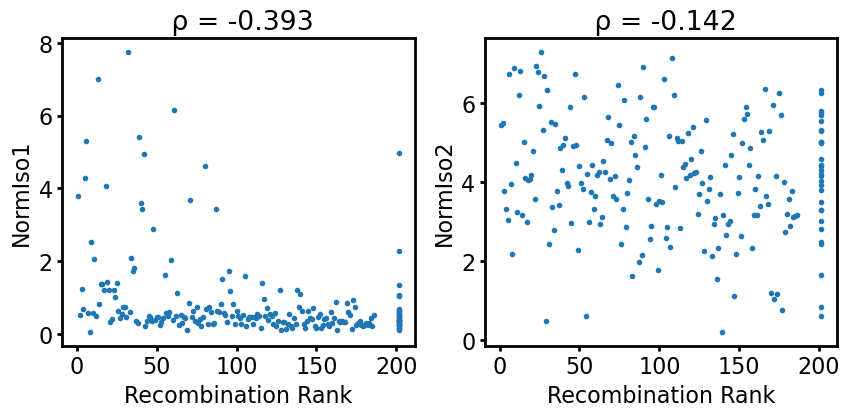

In [54]:
plt.figure(figsize=(10, 4))
for i, column in enumerate(['NormIso1', 'NormIso2']):
    plt.subplot(1, 2, i+1)
    fitness_df2 = fitness_df.dropna(subset=[column+ '_recomb_rank'])
    plt.plot(fitness_df2[column+ '_recomb_rank'], fitness_df2[column], '.')
    spearman_value = spearmanr(fitness_df2[column +'_recomb_rank'].values, fitness_df2[column].values)[0]
    plt.title(' \u03C1 = ' + str(round(spearman_value,3)))
    plt.xlabel('Recombination Rank')
    plt.ylabel(column)
plt.tight_layout

### Plot the distribution of single mutants at each position

In [25]:
df = pd.read_csv('/home/jyang4/repos/data/from_StARDUST/ParPgb/4site_shilong/ParPgb_normalized_grouped.csv')
# df = df.groupby('Combo', as_index=False ).mean()
# df = df.sort_values('R2', ascending=False).reset_index()
# df.drop('index', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
#concatenate F to the end of Combo
df['SimpleCombo'] = df['Combo'] + 'F'
df

,Combo,VariantsFound,AlignmentFrequency,WellSeqDepth,R1,R2,R3,SimpleCombo
0,SVQL,4.0,0.986928,153.0,0.510418,2.224489,0.829334,SVQLF
1,LLVG,4.0,0.992754,138.0,0.870361,2.130468,0.626610,LLVGF
2,LNSF,4.0,0.972973,333.0,1.183606,2.089798,1.649631,LNSFF
3,IYLG,3.0,0.986159,289.0,0.086782,2.005594,0.961238,IYLGF
4,FNEF,4.0,0.974138,232.0,1.136807,1.932296,1.865204,FNEFF
...,...,...,...,...,...,...,...,...
175,LHIR,4.0,1.000000,113.0,0.000000,0.148452,0.574535,LHIRF
176,GHCS,4.0,0.960938,256.0,0.000000,0.131978,2.039982,GHCSF
177,EFIR,4.0,0.956522,138.0,0.138874,0.107159,1.364697,EFIRF
178,V*YG,4.0,0.981132,159.0,0.000000,0.101111,0.105179,V*YGF


Text(0.5, 0, 'Fitness')

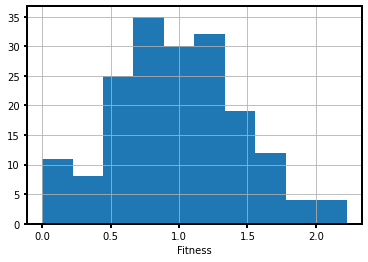

In [26]:
df['R2'].hist()
plt.xlabel('Fitness')

15


/tmp/ipykernel_114155/4107771774.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['SimpleCombo'].apply(lambda x: x[l])
/tmp/ipykernel_114155/4107771774.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['SimpleCombo'].apply(lambda x: x[l])
/tmp/ipykernel_114155/4107771774.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

86


/tmp/ipykernel_114155/4107771774.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['SimpleCombo'].apply(lambda x: x[l])
/tmp/ipykernel_114155/4107771774.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['SimpleCombo'].apply(lambda x: x[l])
/tmp/ipykernel_114155/4107771774.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

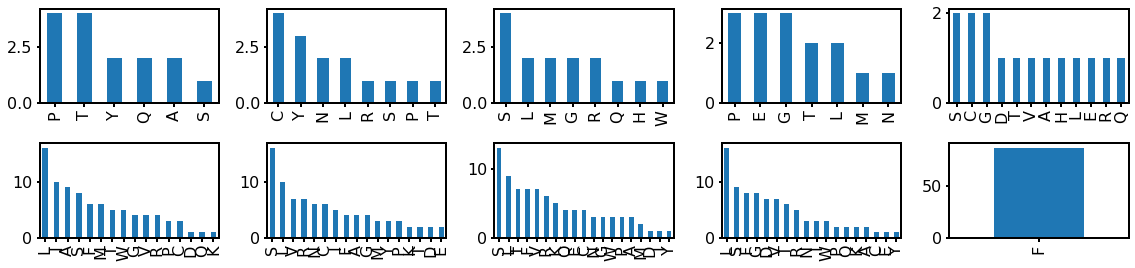

In [75]:
plt.figure(figsize=(16, 4))
for i in [1]:
    for j in  [0, 1]:
        sites = 5
        labels = ['AA1', 'AA2', 'AA3', 'AA4', 'AA5']
        if j == 0:
            batch = cleaned_merged[cleaned_merged['Area2'] > 1.2] # can also use 1
        
        #second column is the distribution of live variants
        if j == 1:
            batch = df[df['R2'] > 1]

        print(len(batch))
        
        for l in range(sites):
            batch['AA' + str(l+1)] = batch['SimpleCombo'].apply(lambda x: x[l])

        for k, label  in enumerate(labels):
            plt.subplot(2, 5, k + 5*j + 1)
            batch[label].value_counts().plot(kind="bar")
            #sns.countplot(x=label, data=batch)
    plt.tight_layout()

### Look at correlations to ZS scores

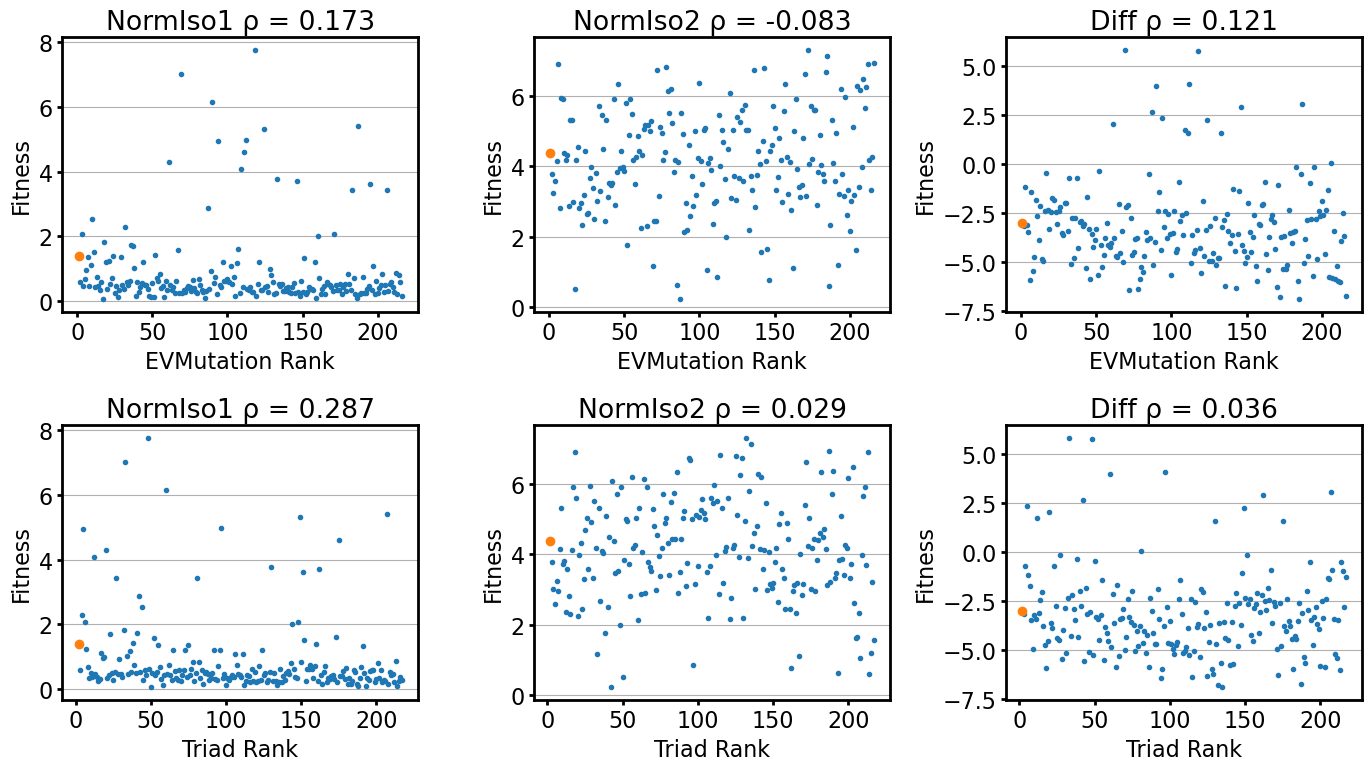

In [13]:
plt.figure(figsize=(14, 8))
for i,zs in enumerate(['EVMutation Rank', 'Triad Rank']):
    merged = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv')
    for j, reaction in enumerate(['NormIso1', 'NormIso2', 'Diff']):

        # fitness = merged[reaction]
        # fitness[fitness == np.inf] = np.min(fitness)
        # merged['norm_fit'] = fitness/np.nanmax(fitness)

        #zs = 'Triad Rank'
        
        #zs = 'Naive Rank'
        #merged['Naive Rank'] = merged['indep_fit'].rank(ascending = False)

        WT_combo = 'WYLQF'

        WT_df = merged[merged['Combo'] == WT_combo]

        plt.subplot(2,3, 3*i + j+1)
        plt.plot(merged[zs], merged[reaction], '.')
        plt.plot(WT_df[zs], WT_df[reaction], 'o')
        plt.title( reaction + ' \u03C1 = ' + str(round(spearmanr(-merged[zs].values, merged[reaction].values)[0],3)))
        plt.grid(axis='y')
        #plt.xlim(0, 96)
        plt.xlabel(zs)
        plt.ylabel('Fitness')
plt.tight_layout()

SignificanceResult(statistic=0.5524428726229175, pvalue=1.1720170803151053e-18)

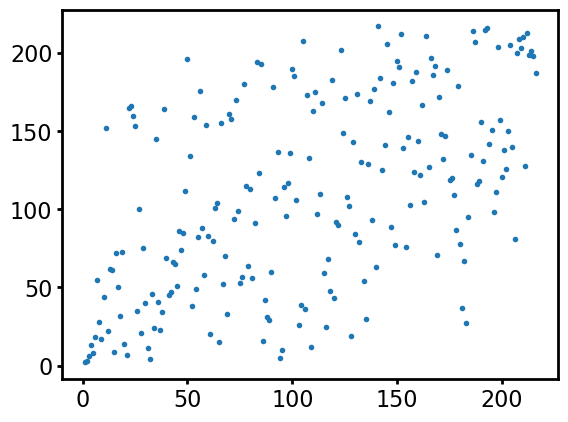

In [15]:
plt.plot(merged['EVMutation Rank'], merged['Triad Rank'], '.')
spearmanr(merged['EVMutation Rank'].values, merged['Triad Rank'].values)

#### EvCouplings (needs to run in Bruce's mlde2 environment due to deprecated versions)

In [1]:
from evcouplings.couplings import CouplingsModel
from evcouplings.mutate import predict_mutation_table, single_mutant_matrix
import pandas as pd

In [2]:
library2sitesdict = {'Par': [56,57,59, 60, 89],
                        'Ape': [59,60,62, 63]
                          }

def get_evcouplings(WTs, sites, final):

    all_mutations = []
    for index, row in final.iterrows():
        mutations = []
        for i, residue in enumerate([row['Combo'][0], row['Combo'][1], row['Combo'][2], row['Combo'][3], row['Combo'][4]]):
            if residue != WTs[i]:
                mutations.append((sites[i], WTs[i], residue))
        all_mutations.append(mutations)
    
    model = CouplingsModel('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/ParPgb.model')
    def mut2effect(mutations):
        dE, _, _ = model.delta_hamiltonian(mutations)
        return dE
    
    final['Mutations'] = all_mutations
    final['EVMutation'] = final['Mutations'].apply(mut2effect)
    final['EVMutation Rank'] = final['EVMutation'].rank(ascending = False)
    final = final.drop(['Mutations'], axis=1)
    return final

def process_library(library):
    sites = library2sitesdict[library]
    WTs = ['W', 'Y', 'W', 'V', 'F']
    WT_combo = ''.join(WTs)

    #triad_df = load_input('/home/jyang4/repos/triad_struct/results/Tm9D8s/Tm9D8s_3site' + library + '_fixed/Tm9D8s_fixed.txt', WT_combo)

    fitness_df = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv')

    df = get_evcouplings(WTs, sites, fitness_df)

    #merged = df.merge(triad_df[['Combo', 'Triad Score', 'Triad Rank']], left_on='Combo', right_on='Combo')

    ### For generating random/independent data and testing overfitting
    #df = pd.read_csv('data/fitness.csv')
    # single_fits = []

    # for i in range(3):
    #     choices = [0, 1, 2]
    #     choices.remove(i)
    #     singles = df[df['Combo'].str[choices[0]] + df['Combo'].str[choices[1]] == WT_combo[:i] + WT_combo[i+1:]]
    #     singles['AA'] = singles['Combo'].str[i]
    #     dict = singles.set_index('AA').to_dict()['fit']
    #     single_fits.append(dict)

    # all_combos = {}
    # for key0 in single_fits[0]:
    #     for key1 in single_fits[1]:
    #         for key2 in single_fits[2]:
    #             all_combos[key0 + key1 + key2] = single_fits[0][key0] * single_fits[1][key1] * single_fits[2][key2]

    # indep = pd.DataFrame(all_combos.items(), columns = ['Combo', 'indep_fit'])

    # merged = merged.merge(indep, on='Combo', how='inner')

    #merged.to_csv('Lib' + library + '_processed.csv', index=None)

    return df

In [4]:
pardf = process_library('Par')
pardf
#pardf.to_csv('ApePgb_merged_all.csv')

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [38]:
def clean(well):
    if len(well) == 2:
        well = well[0] + '0' + well[1]
    return well

evseq_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/ParPgb/4site_shilong//Par_AminoAcids_Coupled_Max.csv')
evseq_df = evseq_df[evseq_df['VariantCombo'] != '#DEAD#']
evseq_df['Plate'] = evseq_df['Plate'].str[-2:]

fitness_df1 = pd.read_csv('/home/jyang4/repos/StARDUST/data/ParPgb/4site_shilong/plate_data_for_ParPgb_R1.csv')
fitness_df1['Plate'] = fitness_df1['Plate'].str[-2:]
fitness_df1['Well'] = fitness_df1['Well'].apply(clean)

fitness_df2 = pd.read_csv('/home/jyang4/repos/StARDUST/data/ParPgb/4site_shilong/plate_data_for_ParPgb_R2.csv')
fitness_df2['Plate'] = fitness_df2['Plate'].str[-2:]
fitness_df2['Well'] = fitness_df2['Well'].apply(clean)

fitness_df3 = pd.read_csv('/home/jyang4/repos/StARDUST/data/ParPgb/4site_shilong/plate_data_for_ParPgb_R3.csv')
fitness_df3['Plate'] = fitness_df3['Plate'].str[-2:]
fitness_df3['Well'] = fitness_df3['Well'].apply(clean)

In [39]:
dict = {'56': 'W', '57': 'Y', '59': 'W', '60': 'V'}
chosen = evseq_df['VariantCombo'].values
processed = [''.join(text).split('_') for text in chosen]
full = []
for entry in processed:
    string = ''
    new_dict = dict.copy()
    for mutation in entry:
        new_dict[mutation[1:3]] = mutation[3]
    for site in dict.keys():
        string += new_dict[site] 
    
    full.append(string)
evseq_df['Combo'] = full

In [46]:
merged = evseq_df.merge(fitness_df1[['Well', 'Plate', 'R1']], on=['Well', 'Plate'])
merged = merged.merge(fitness_df2[['Well', 'Plate', 'R2']], on=['Well', 'Plate'])
merged = merged.merge(fitness_df3[['Well', 'Plate', 'R3']], on=['Well', 'Plate'])
merged

,IndexPlate,Plate,Well,VariantCombo,SimpleCombo,VariantsFound,AlignmentFrequency,WellSeqDepth,VariantSequence,Flags,Combo,R1,R2,R3
0,DI03,P1,A02,W56S_Y57L_W59*_V60F,SL*F,4,1.000000,153,RKMACEALKGQVEDILDLSLG*FGSNQHLIYYFGDKSGRPIPQYLE...,NaN,SL*F,43.0006,895.0942,129687.7748
1,DI03,P1,A03,W56I_Y57G_W59C_V60G,IGCG,4,0.953947,152,RKMACEALKGQVEDILDLIGGCGGSNQHLIYYFGDKSGRPIPQYLE...,NaN,IGCG,52.8453,1175.0775,130891.3001
2,DI03,P1,A04,W56V_Y57C_W59L,VCL,3,0.994012,167,RKMACEALKGQVEDILDLVCGLVGSNQHLIYYFGDKSGRPIPQYLE...,NaN,VCLV,0.0000,816.7589,9488.2223
3,DI03,P1,A05,W56S_Y57S_W59T_V60T,SSTT,4,0.954545,110,RKMACEALKGQVEDILDLSSGTTGSNQHLIYYFGDKSGRPIPQYLE...,NaN,SSTT,62.9650,970.6160,113598.0525
4,DI03,P1,A06,W56K_Y57C_W59F_V60W,KCFW,4,0.989247,279,RKMACEALKGQVEDILDLKCGFWGSNQHLIYYFGDKSGRPIPQYLE...,NaN,KCFW,13.9918,728.6112,131961.7610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,DI04,P2,H06,W56A_Y57I_W59I_V60R,AIIR,4,0.976608,171,RKMACEALKGQVEDILDLAIGIRGSNQHLIYYFGDKSGRPIPQYLE...,NaN,AIIR,35.8072,851.7509,121202.0070
177,DI04,P2,H07,Y57F_V60M,FM,2,0.986014,143,RKMACEALKGQVEDILDLWFGWMGSNQHLIYYFGDKSGRPIPQYLE...,NaN,WFWM,10.8466,267.9215,51544.4338
178,DI04,P2,H08,W56M_Y57G_W59T_V60L,MGTL,4,0.984556,259,RKMACEALKGQVEDILDLMGGTLGSNQHLIYYFGDKSGRPIPQYLE...,NaN,MGTL,61.6478,1663.3788,186288.1625
179,DI04,P2,H10,W56L_Y57N_W59S_V60F,LNSF,4,0.972973,333,RKMACEALKGQVEDILDLLNGSFGSNQHLIYYFGDKSGRPIPQYLE...,NaN,LNSF,280.4580,2008.6722,186270.1657


In [47]:
merged[merged['Combo'] == 'WYLQ']

,IndexPlate,Plate,Well,VariantCombo,SimpleCombo,VariantsFound,AlignmentFrequency,WellSeqDepth,VariantSequence,Flags,Combo,R1,R2,R3
53,DI03,P1,E09,W59L_V60Q,LQ,2,0.921429,140,RKMACEALKGQVEDILDLWYGLQGSNQHLIYYFGDKSGRPIPQYLE...,NaN,WYLQ,232.4119,1060.936,103991.4778
113,DI04,P2,C01,W59L_V60Q,LQ,2,0.988550,262,RKMACEALKGQVEDILDLWYGLQGSNQHLIYYFGDKSGRPIPQYLE...,NaN,WYLQ,236.9521,961.180,112916.2382


In [49]:
#normalize to the parent on each plate
for plate in ['P1', 'P2']:
    plate_df =  merged[merged['Plate'] == plate]
    for reaction in ['R1', 'R2', 'R3']:
        mean = plate_df[plate_df['Combo'] == 'WYLQ'][reaction].mean()
        #divide rows in cleaned_df by mean for that plate
        merged.loc[merged['Plate'] == plate, reaction] = merged.loc[merged['Plate'] == plate, reaction]/mean
merged

,IndexPlate,Plate,Well,VariantCombo,SimpleCombo,VariantsFound,AlignmentFrequency,WellSeqDepth,VariantSequence,Flags,Combo,R1,R2,R3
0,DI03,P1,A02,W56S_Y57L_W59*_V60F,SL*F,4,1.000000,153,RKMACEALKGQVEDILDLSLG*FGSNQHLIYYFGDKSGRPIPQYLE...,NaN,SL*F,0.185019,0.843684,1.247100
1,DI03,P1,A03,W56I_Y57G_W59C_V60G,IGCG,4,0.953947,152,RKMACEALKGQVEDILDLIGGCGGSNQHLIYYFGDKSGRPIPQYLE...,NaN,IGCG,0.227378,1.107586,1.258673
2,DI03,P1,A04,W56V_Y57C_W59L,VCL,3,0.994012,167,RKMACEALKGQVEDILDLVCGLVGSNQHLIYYFGDKSGRPIPQYLE...,NaN,VCLV,0.000000,0.769847,0.091240
3,DI03,P1,A05,W56S_Y57S_W59T_V60T,SSTT,4,0.954545,110,RKMACEALKGQVEDILDLSSGTTGSNQHLIYYFGDKSGRPIPQYLE...,NaN,SSTT,0.270920,0.914868,1.092378
4,DI03,P1,A06,W56K_Y57C_W59F_V60W,KCFW,4,0.989247,279,RKMACEALKGQVEDILDLKCGFWGSNQHLIYYFGDKSGRPIPQYLE...,NaN,KCFW,0.060203,0.686763,1.268967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,DI04,P2,H06,W56A_Y57I_W59I_V60R,AIIR,4,0.976608,171,RKMACEALKGQVEDILDLAIGIRGSNQHLIYYFGDKSGRPIPQYLE...,NaN,AIIR,0.151116,0.886151,1.073380
177,DI04,P2,H07,Y57F_V60M,FM,2,0.986014,143,RKMACEALKGQVEDILDLWFGWMGSNQHLIYYFGDKSGRPIPQYLE...,NaN,WFWM,0.045775,0.278742,0.456484
178,DI04,P2,H08,W56M_Y57G_W59T_V60L,MGTL,4,0.984556,259,RKMACEALKGQVEDILDLMGGTLGSNQHLIYYFGDKSGRPIPQYLE...,NaN,MGTL,0.260170,1.730559,1.649791
179,DI04,P2,H10,W56L_Y57N_W59S_V60F,LNSF,4,0.972973,333,RKMACEALKGQVEDILDLLNGSFGSNQHLIYYFGDKSGRPIPQYLE...,NaN,LNSF,1.183606,2.089798,1.649631


In [57]:
merged = merged.groupby('Combo').mean().reset_index().sort_values('R2', ascending=False)

In [58]:
merged.to_csv('ParPgb_normalized_grouped.csv')

In [16]:
all_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/ParPgb/ParPgb_merged_all.csv')
all_df[(all_df['Plate'] == 'P2') & (all_df['Well'] == 'C01')]

,Unnamed: 0,IndexPlate,Plate,Well,VariantCombo,SimpleCombo,VariantsFound,AlignmentFrequency,WellSeqDepth,VariantSequence,Flags,Combo,R1,R2,R3,Triad Score,Triad Rank,EVMutation,EVMutation Rank
47,47,DI04,P2,C01,W59L_V60Q,LQ,2,0.98855,262,RKMACEALKGQVEDILDLWYGLQGSNQHLIYYFGDKSGRPIPQYLE...,NaN,WYLQ,236.9521,961.18,112916.2382,-663.58126,3,-10.557092,4.5


In [7]:
fitness = pd.read_csv('/home/jyang4/repos/data/Tm9D8s_fitness.csv')
#fitness[fitness['Combo'] == 'VFVS']
fitness[fitness['Combo'] == 'AAAR']

,Combo,Fitness,EvMutation,Triad Score,esm2_t33_650M_UR50D-Naive,ESM2 Ranking,Triad Inverse Ranking
14,AAAR,0.017559,-14.467834,-1419.36197,-21.421914,12362.0,86615.0


### Add on the triad scores

In [1]:
def load_input(triad_output_file, WT_combo, num_seqs):
    
    # Load the output file
    with open(triad_output_file) as f:

        # Set some flags for starting analysis
        solutions_started = False
        record_start = False

        # Begin looping over the file
        summary_lines = []
        for line in f:

            # Start looking at data once we hit "solution"
            #if "Solution" in line:
            if "All sequences:" in line:
                solutions_started = True

            # Once we have "Index" we can start recording the rest
            if solutions_started and "Index" in line:
                record_start = True

            # Record appropriate data
            if record_start:

                # Strip the newline and split on whitespace
                summary_line = line.strip().split()

                # If we have hit "Average" stop the whole look
                #if summary_line[0] == "Average":
                #    break

                # Otherwise, append the line
                summary_lines.append(summary_line)

                #if summary_line[0] == '7999':
                if summary_line[0] == str(num_seqs):
                    break

    # Build the dataframe
    all_results = pd.DataFrame(summary_lines[1:], columns = summary_lines[0])
    all_results["Triad Score"] = all_results.Score.astype(float)
    
    wt_chars = WT_combo
    reconstructed_combos = ["".join([char if char != "-" else wt_chars[i] for i, char in enumerate(seq)])
                            for seq in all_results.Seq.values]
    all_results["Combo"] = reconstructed_combos

    # Attach fitness
    #all_results["Fitness"] = all_results.Fitness.values / all_results.Fitness.values.max()
    
    #all_results.loc[all_results['Muts'] == 'WT', 'Fitness'] = 1
    #all_results = all_results[all_results['Fitness'].notna()]
    # Get the order
    all_results["Triad Rank"] = np.arange(1, len(all_results) + 1)
    
    # Split aas into different columns
    #all_results[["AA1", "AA2", "AA3", "AA4"]] = all_results.Combo.apply(lambda x: pd.Series(list(x)))
    
    return all_results

all_df = load_input('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/ParPgb_5site_triad_fixed.txt', 'WYWVF', 216)

In [6]:

all_df

,Index,Tags,Score,Seq,Muts,Triad Score,Combo,Triad Rank
0,0,WT,-666.30091,-----,WT,-666.30091,WYWVF,1
1,1,"A_59L+A_60Q,59",-663.60981,--LQ-,A_59L+A_60Q,-663.60981,WYLQF,2
2,2,"A_59Q+A_60Q,181",-661.23234,--QQ-,A_59Q+A_60Q,-661.23234,WYQQF,3
3,3,"A_56H+A_57L+A_59V+A_60L+A_89W,121",-656.70887,HLVLW,A_56H+A_57L+A_59V+A_60L+A_89W,-656.70887,HLVLW,4
4,4,"A_56S+A_57W+A_60S+A_89W,138",-656.62676,SW-SW,A_56S+A_57W+A_60S+A_89W,-656.62676,SWWSW,5
...,...,...,...,...,...,...,...,...
212,212,"A_56P+A_57P+A_59H+A_60N+A_89G,63",-615.69023,PPHNG,A_56P+A_57P+A_59H+A_60N+A_89G,-615.69023,PPHNG,213
213,213,"A_56P+A_57A+A_59S+A_60L+A_89P,130",-615.60940,PASLP,A_56P+A_57A+A_59S+A_60L+A_89P,-615.60940,PASLP,214
214,214,"A_56T+A_57N+A_59M+A_60P+A_89P,186",-615.12883,TNMPP,A_56T+A_57N+A_59M+A_60P+A_89P,-615.12883,TNMPP,215
215,215,"A_56A+A_57K+A_59P+A_60P+A_89R,164",-614.46968,AKPPR,A_56A+A_57K+A_59P+A_60P+A_89R,-614.46968,AKPPR,216


In [7]:
merged = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv')
merged

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff,EVMutation,EVMutation Rank
0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,7.020661,1,1.171488,5.849174,-28.982647,69.0
1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,7.757700,1,1.977413,5.780287,-31.842763,118.0
2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,4.960080,1,0.854291,4.105788,-31.299863,112.0
3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,6.152918,1,2.136821,4.016097,-29.967584,90.0
4,AKPPY,75.0,0.774387,175.0,7.0,497.0,2692.0,1163.0,5.416499,1,2.340040,3.076459,-35.509484,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,VCRAS,190.0,0.476841,297.0,4.0,501.0,200.0,3415.0,0.399202,1,6.816367,-6.417166,-29.500047,78.0
212,HDNMN,173.0,0.155533,277.0,4.0,501.0,148.0,3378.0,0.295409,1,6.742515,-6.447106,-29.217710,72.0
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.173913,1,6.942688,-6.768775,-38.626022,216.0
214,ACSEK,60.0,0.655179,483.0,8.0,490.0,243.0,3579.0,0.495918,1,7.304082,-6.808163,-34.614352,172.0


In [8]:
merged_new = merged.merge(all_df[['Combo', 'Triad Score', 'Triad Rank']],on='Combo')
merged_new

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,NormIso1,num_wells,NormIso2,Diff,EVMutation,EVMutation Rank,Triad Score,Triad Rank
0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,7.020661,1,1.171488,5.849174,-28.982647,69.0,-648.97722,33
1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,7.757700,1,1.977413,5.780287,-31.842763,118.0,-646.67160,48
2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,4.960080,1,0.854291,4.105788,-31.299863,112.0,-642.32678,97
3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,6.152918,1,2.136821,4.016097,-29.967584,90.0,-645.07324,60
4,AKPPY,75.0,0.774387,175.0,7.0,497.0,2692.0,1163.0,5.416499,1,2.340040,3.076459,-35.509484,187.0,-618.95309,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,VCRAS,190.0,0.476841,297.0,4.0,501.0,200.0,3415.0,0.399202,1,6.816367,-6.417166,-29.500047,78.0,-641.07042,115
212,HDNMN,173.0,0.155533,277.0,4.0,501.0,148.0,3378.0,0.295409,1,6.742515,-6.447106,-29.217710,72.0,-642.37494,94
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,0.173913,1,6.942688,-6.768775,-38.626022,216.0,-629.35627,187
214,ACSEK,60.0,0.655179,483.0,8.0,490.0,243.0,3579.0,0.495918,1,7.304082,-6.808163,-34.614352,172.0,-639.54535,132


In [9]:
merged_new.to_csv('Pgb_fitness.csv', index=None)